# Automated Analysis for Multiple Time Series 

- Author: Israel Oliveira [\[e-mail\]](mailto:'Israel%20Oliveira%20'<prof.israel@gmail.com>)

In [1]:
%load_ext watermark

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from cycler import cycler

rcParams['figure.figsize'] = 18, 5
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.grid'] = True
rcParams['axes.prop_cycle'] = cycler(color=['#365977'])
rcParams['lines.linewidth'] = 2.5

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
import antropy as ant
from statsmodels.tsa.stattools import adfuller

In [3]:
from tqdm import tqdm

from glob import glob

# import matplotlib.pyplot as plt
# %matplotlib inline
# from IPython.core.pylabtools import figsize
# figsize(12, 8)

# import seaborn as sns
# sns.set_theme()

# pd.set_option("max_columns", None)
# pd.set_option("max_rows", None)
# pd.set_option('display.max_colwidth', None)

from IPython.display import Markdown, display
def md(arg):
    display(Markdown(arg))

# from pandas_profiling import ProfileReport
# #report = ProfileReport(#DataFrame here#, minimal=True)
# #report.to

# import pyarrow.parquet as pq
# #df = pq.ParquetDataset(path_to_folder_with_parquets, filesystem=None).read_pandas().to_pandas()

# import json
# def open_file_json(path,mode='r',var=None):
#     if mode == 'w':
#         with open(path,'w') as f:
#             json.dump(var, f)
#     if mode == 'r':
#         with open(path,'r') as f:
#             return json.load(f)

# import functools
# import operator
# def flat(a):
#     return functools.reduce(operator.iconcat, a, [])

# import json
# from glob import glob
# from typing import NewType


# DictsPathType = NewType("DictsPath", str)


# def open_file_json(path):
#     with open(path, "r") as f:
#         return json.load(f)

# class LoadDicts:
#     def __init__(self, dict_path: DictsPathType = "./data"):
#         Dicts_glob = glob(f"{dict_path}/*.json")
#         self.List = []
#         self.Dict = {}
#         for path_json in Dicts_glob:
#             name = path_json.split("/")[-1].replace(".json", "")
#             self.List.append(name)
#             self.Dict[name] = open_file_json(path_json)
#             setattr(self, name, self.Dict[name])


In [4]:
# Run this cell before close.
%watermark -d --iversion -b -r -g -m -v
!cat /proc/cpuinfo |grep 'model name'|head -n 1 |sed -e 's/model\ name/CPU/'
!free -h |cut -d'i' -f1  |grep -v total

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 7.25.0

Compiler    : GCC 8.3.0
OS          : Linux
Release     : 5.11.0-7620-generic
Machine     : x86_64
Processor   : 
CPU cores   : 4
Architecture: 64bit

Git hash: cc853c29b8365bf369ab46c29f8f3d8ed57b1e0a

Git repo: https://github.com/ysraell/forecasting.git

Git branch: main

numpy     : 1.19.5
pandas    : 1.3.1
antropy   : 0.1.4
matplotlib: 3.4.2

CPU	: Intel(R) Core(TM) i7-7500U CPU @ 2.70GHz
Mem:           15G
Swap:         4.0G


In [5]:

# Get in where diff order the series is stationary.
def stationary_at_diff_order(data: pd.Series, alpha: float = 0.05, max_diff_order: int = 10) -> int:
    # Test to see if the time series is already stationary
    if adfuller(data)[1] < alpha:
        return 0
        
    # Test for differencing orders from 1 to max_diff_order (included)
    for i in range(1, max_diff_order + 1):
        # Perform ADF test
        if adfuller(np.diff(data,i))[1] < alpha:
            return i
    return np.inf

# To compare the energy (how much signifcative) is the signal comparing to another.
def rel_energy(signal: np.ndarray, signal_ref: np.ndarray) -> np.float64:
    return abs(signal).sum()/abs(signal_ref).sum()

# Strength of the trend or seasonality against residual signal (or another signal as you wish).
def strength(signal: np.ndarray, residual: np.ndarray, multi: bool = False) -> np.float64:
    D = np.var(signal*residual) if multi else np.var(signal+residual) 
    return max(1 - np.var(residual)/D, 0)

# antropy.spectral_entropy. sf = 52 = 52 weeks = 1 year
def spectral_entropy(signal: np.ndarray) -> float:
    return ant.spectral_entropy(signal, sf=52, method='fft', normalize=True)

# For relative comparison, the absolute sum is enough.
def sum_acf_pacf(signal: np.ndarray) -> float:
    return abs(acf(signal)).sum(), abs(pacf(signal)).sum()

Dataset: Cryptocurrency Historical Prices. Prices of top cryptocurrencies including BTC, ETH, ADA, DOT and BNB.
Link: https://www.kaggle.com/sudalairajkumar/cryptocurrencypricehistory?select=coin_Bitcoin.csv

**Why bitcoin? It's only to stress the models. Please, do not use this to buy or sell your coins!!! I do not guarantee any investment strategy using this notebook.**

In [6]:
coins_dataset_path = '/work/data/coins'
df = pd.concat([pd.read_csv(csv, parse_dates=True) for csv in glob(f'{coins_dataset_path}/*csv')], ignore_index=True)

In [7]:
df.Date.head()

0    2017-06-14 23:59:59
1    2017-06-15 23:59:59
2    2017-06-16 23:59:59
3    2017-06-17 23:59:59
4    2017-06-18 23:59:59
Name: Date, dtype: object

In [8]:
df['Date'] = pd.to_datetime(df.Date)

In [9]:
df.Date.head()

0   2017-06-14 23:59:59
1   2017-06-15 23:59:59
2   2017-06-16 23:59:59
3   2017-06-17 23:59:59
4   2017-06-18 23:59:59
Name: Date, dtype: datetime64[ns]

In [10]:
Coins = df.Symbol.unique().tolist()

In [11]:
# vide import matplotlib.colors as mcolors; mcolors.TABLEAU_COLORS
col2color = {
    'High':'red',
    'Low':'gray', 
    'Open':'orange',
    'Close':'blue', 
    'Volume':'green',
    'Marketcap':'olive'
}
linestyle = {
    'High':':',
    'Low':':', 
    'Open':'--',
    'Close':'-', 
    'Volume':'-',
    'Marketcap':'-'
}
price_cols = ['High', 'Low', 'Open', 'Close']
other_cols = ['Volume', 'Marketcap']
cols2decomposed = ['Close']
modes2decomposed = ['additive', 'multiplicative']

x must have 2 complete cycles requires 104 observations. x only has 66 observation(s)


/tmp/ipykernel_897/1665367942.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


x must have 2 complete cycles requires 104 observations. x only has 47 observation(s)
x must have 2 complete cycles requires 104 observations. x only has 40 observation(s)
x must have 2 complete cycles requires 104 observations. x only has 43 observation(s)


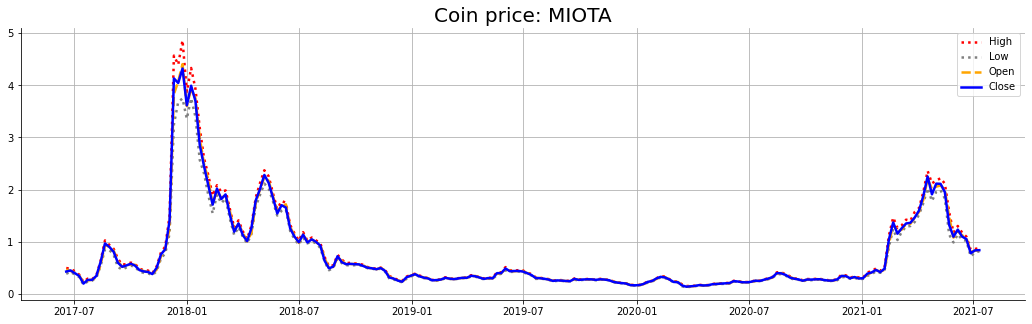

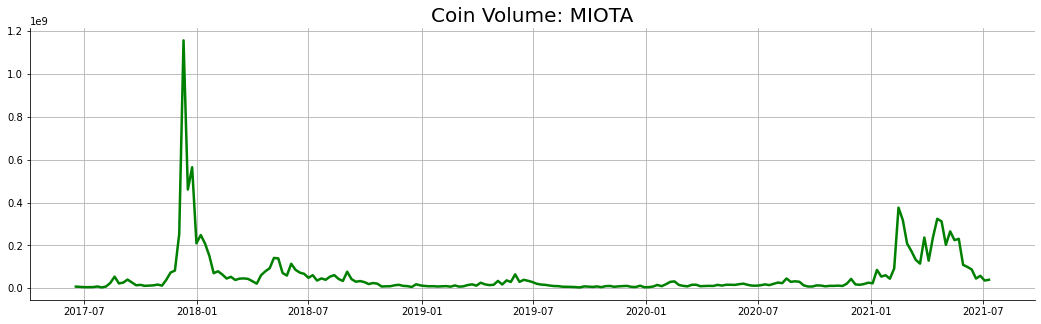

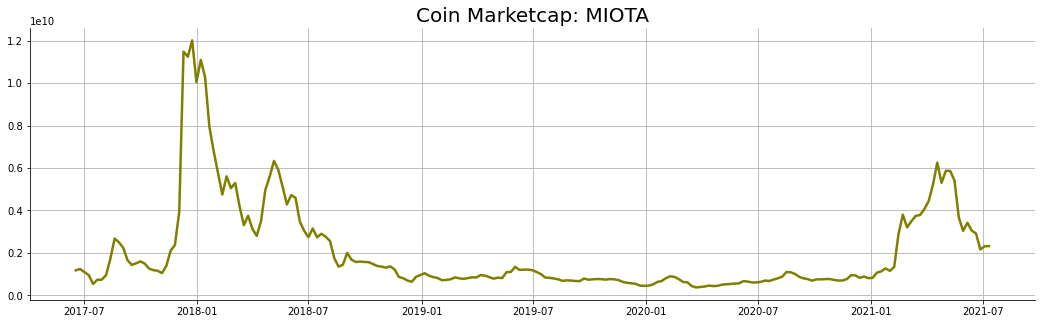

<Figure size 864x576 with 0 Axes>

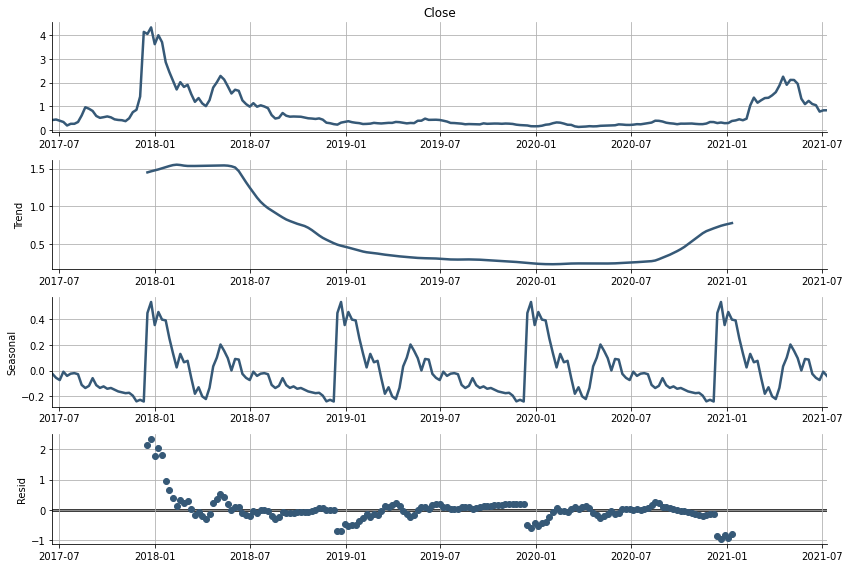

<Figure size 864x576 with 0 Axes>

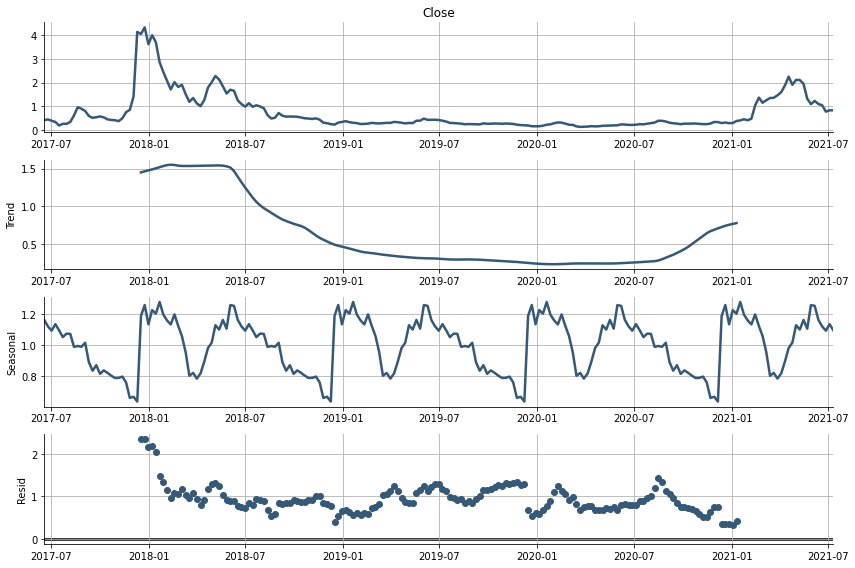

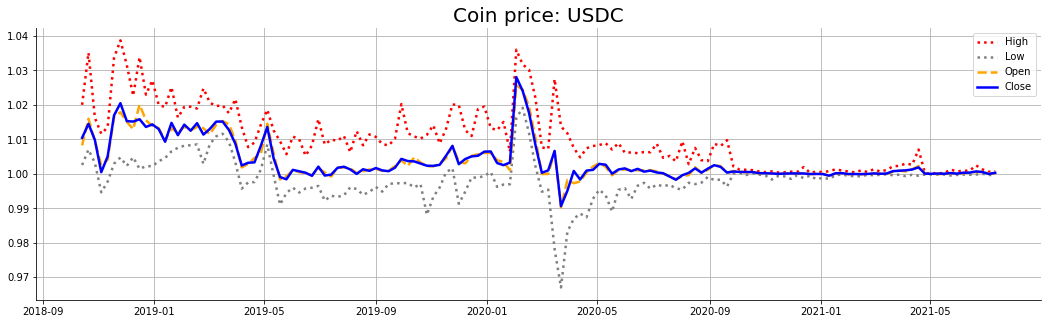

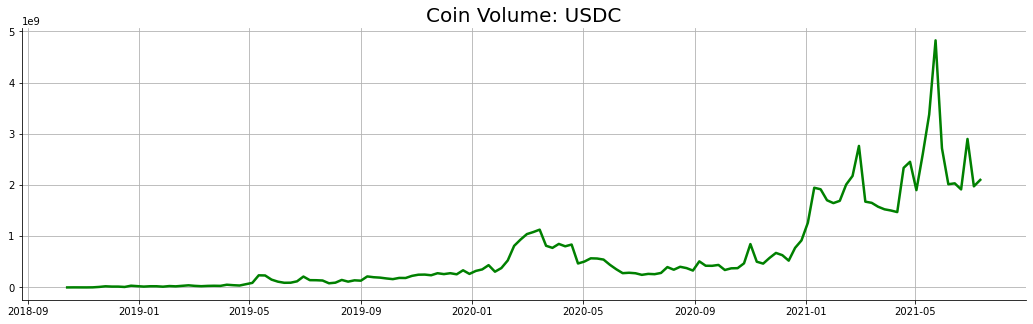

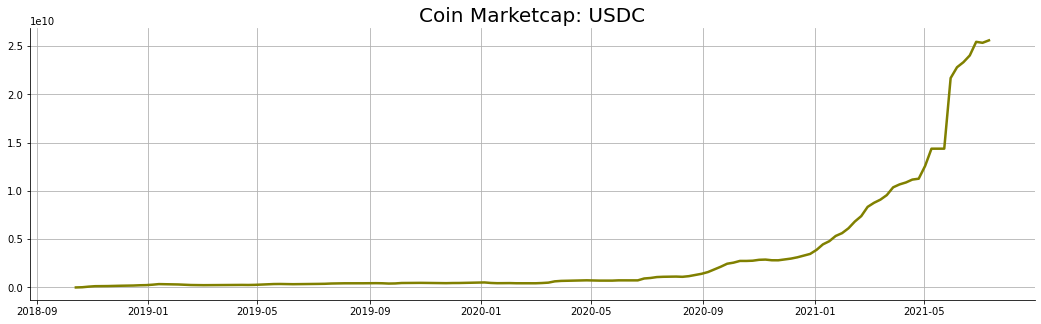

<Figure size 864x576 with 0 Axes>

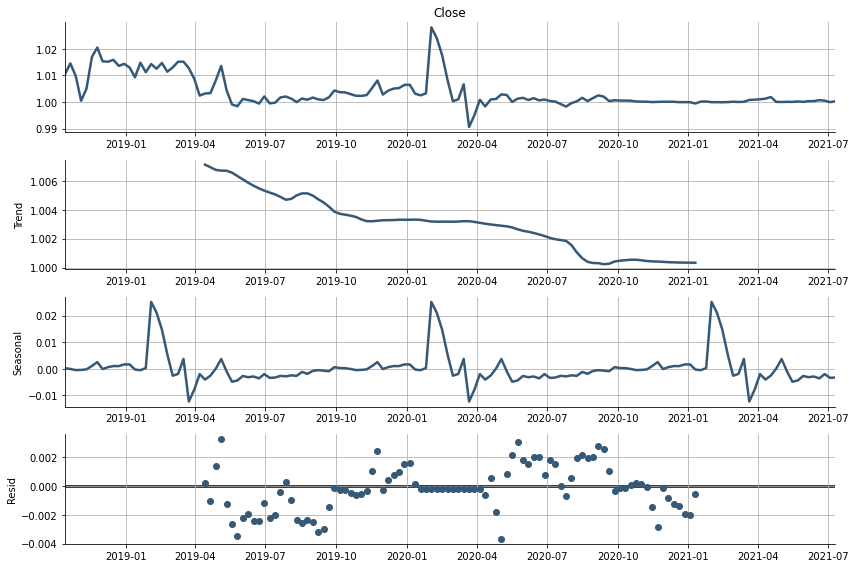

<Figure size 864x576 with 0 Axes>

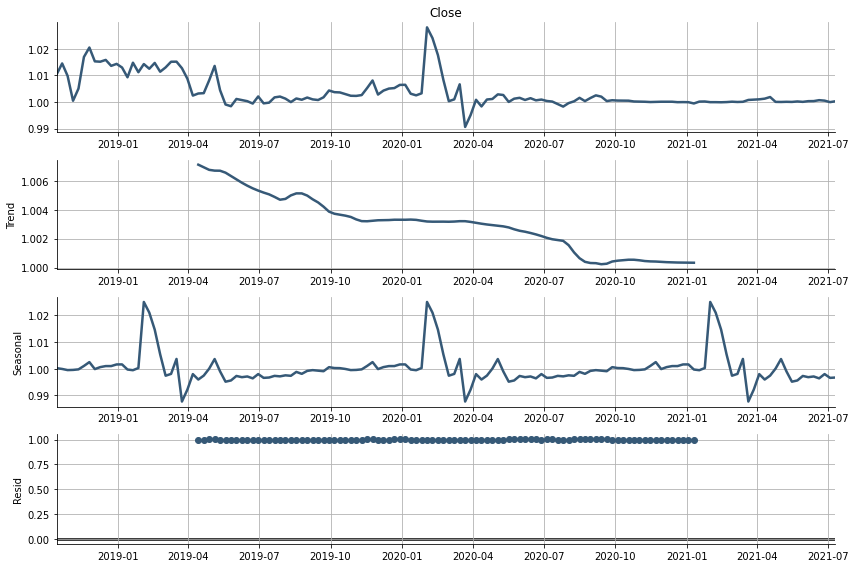

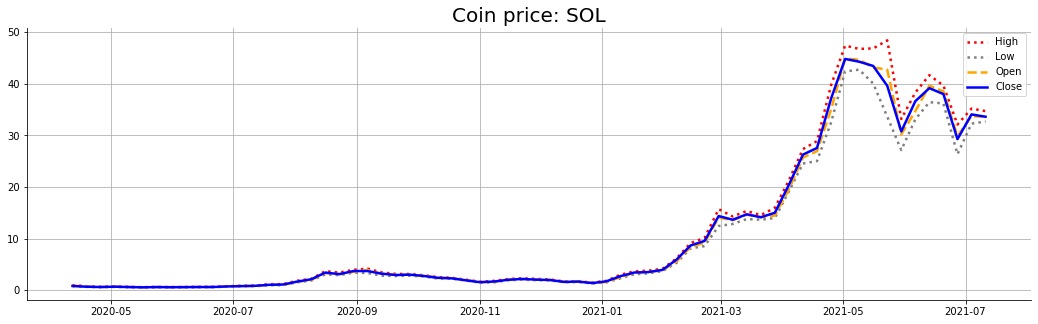

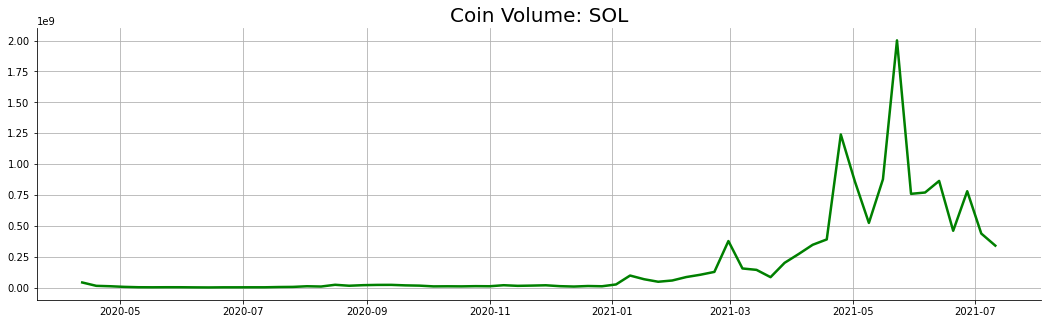

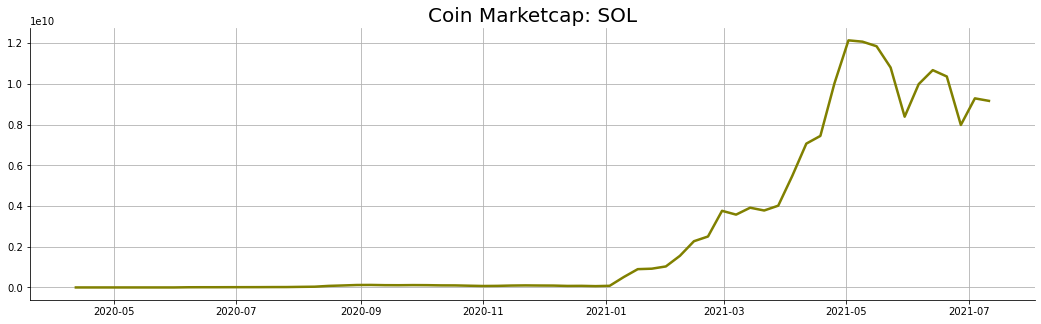

<Figure size 864x576 with 0 Axes>

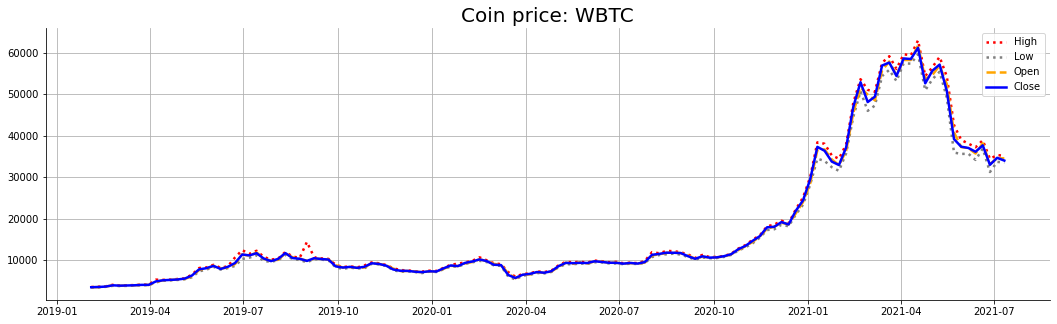

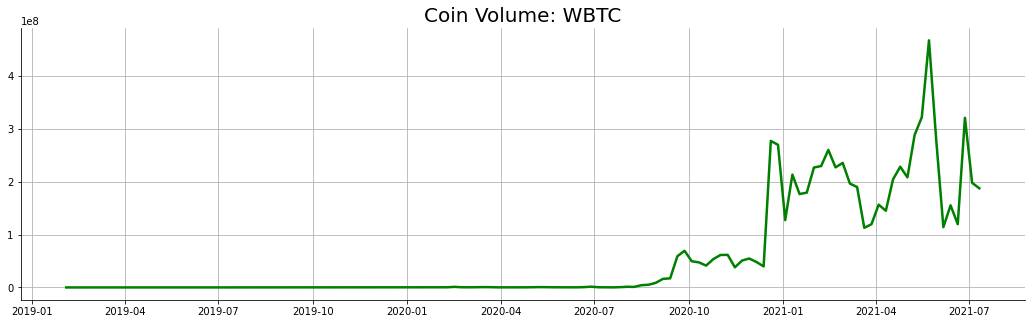

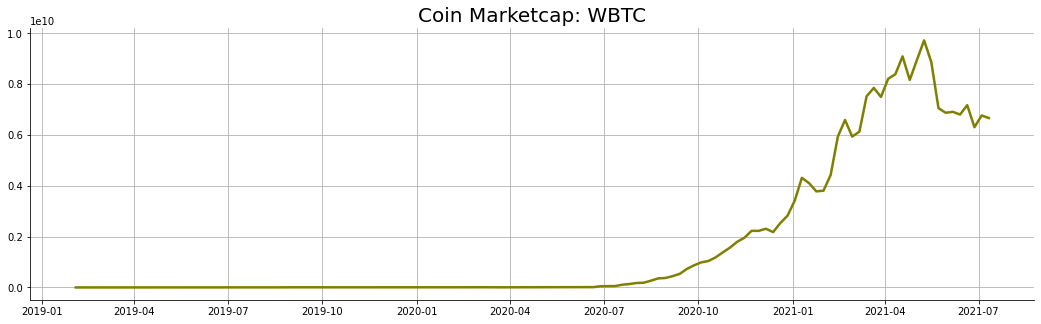

<Figure size 864x576 with 0 Axes>

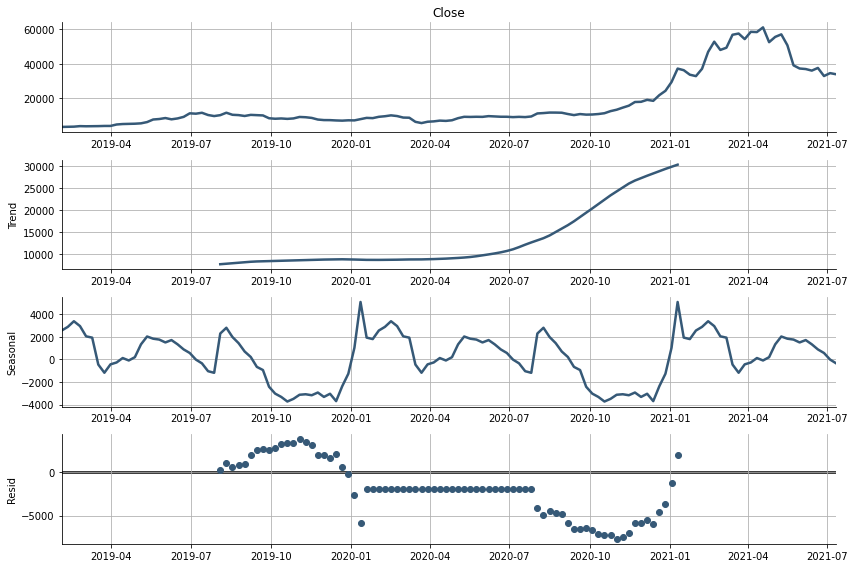

<Figure size 864x576 with 0 Axes>

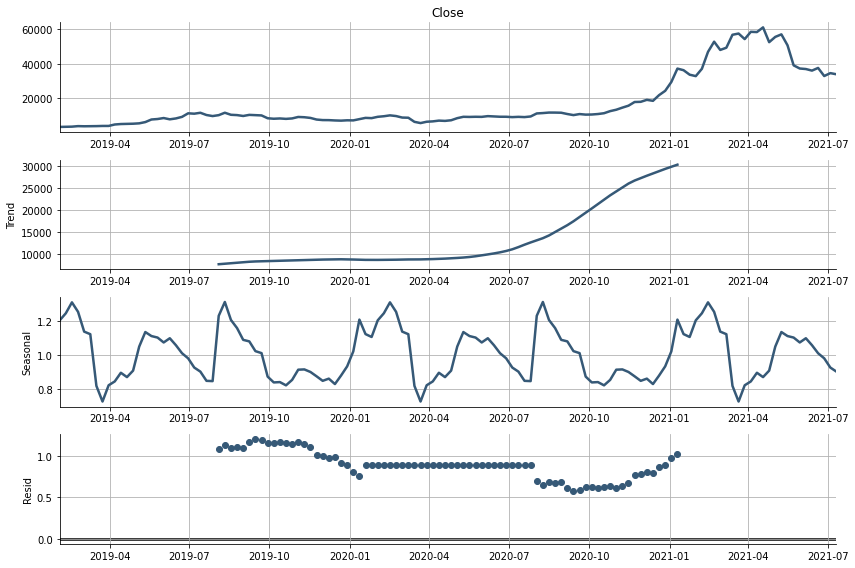

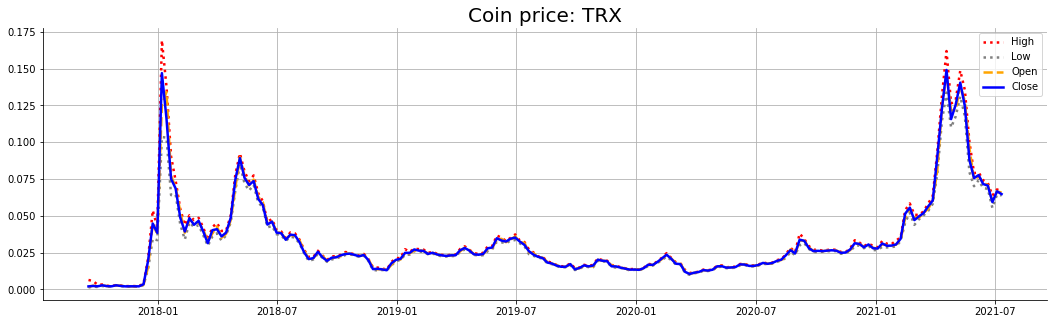

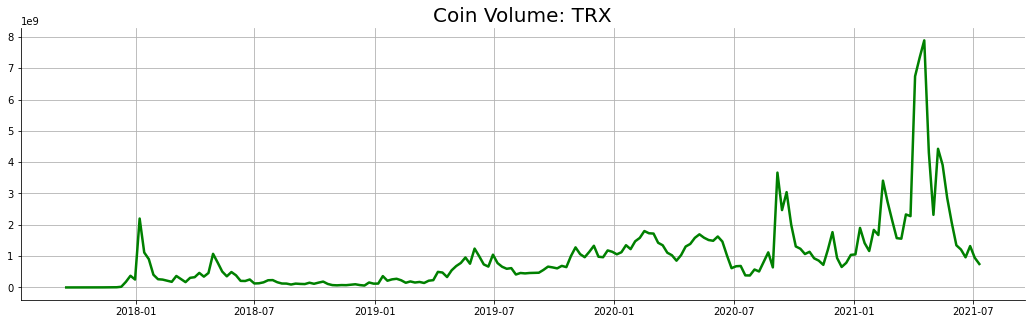

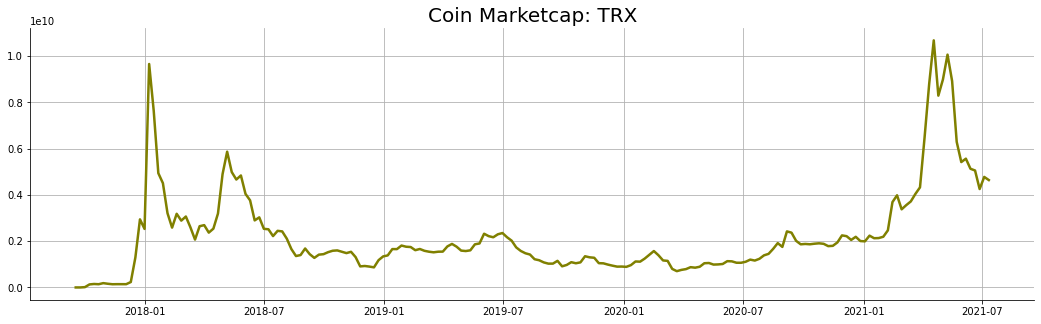

<Figure size 864x576 with 0 Axes>

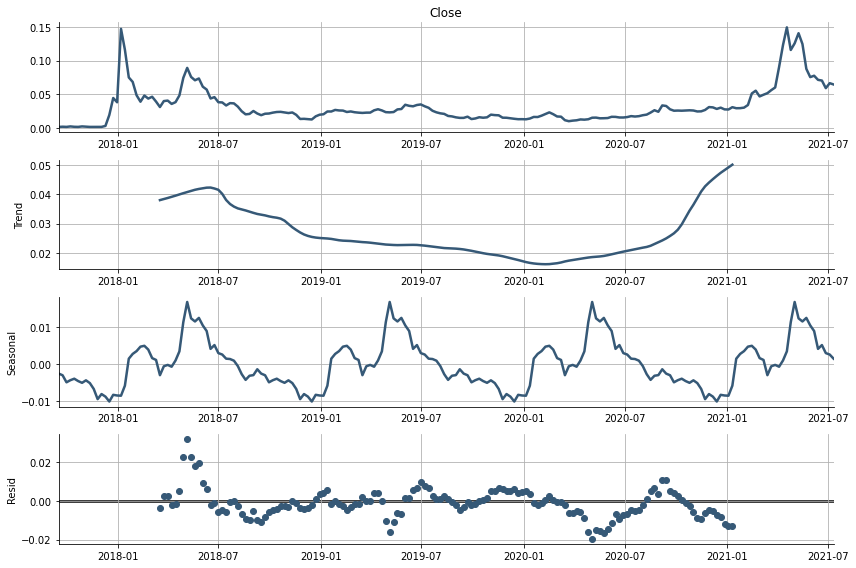

<Figure size 864x576 with 0 Axes>

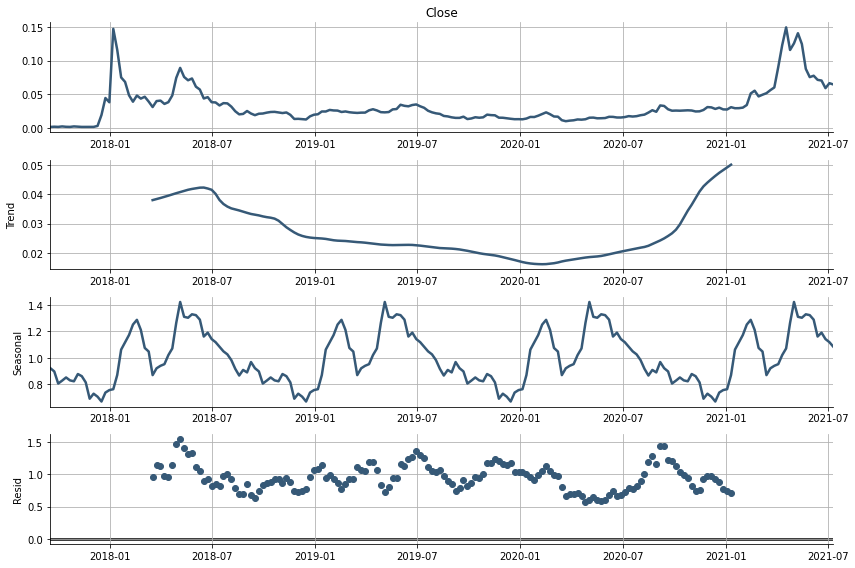

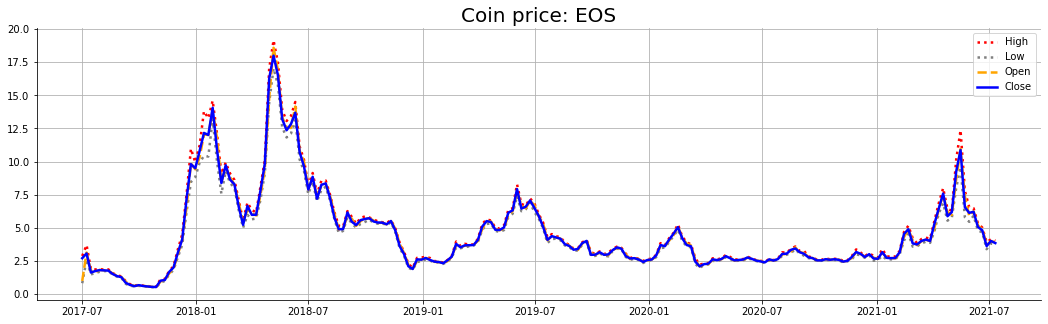

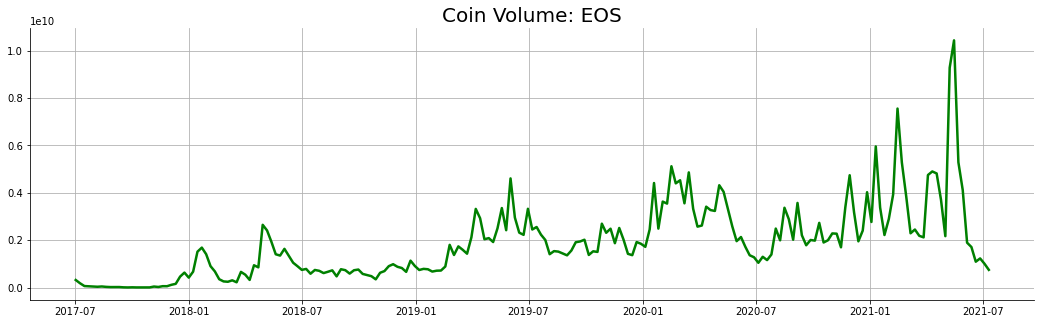

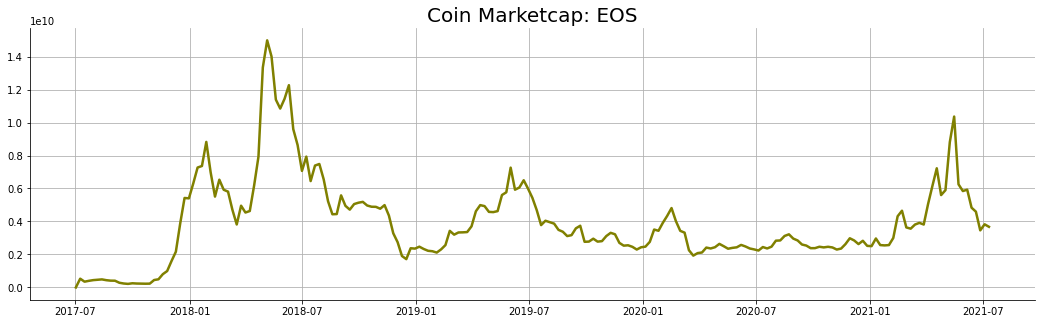

<Figure size 864x576 with 0 Axes>

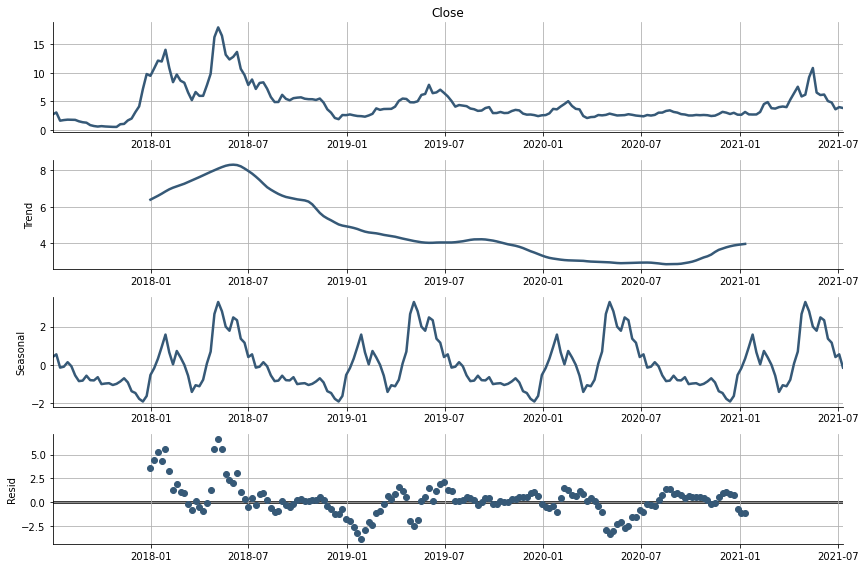

<Figure size 864x576 with 0 Axes>

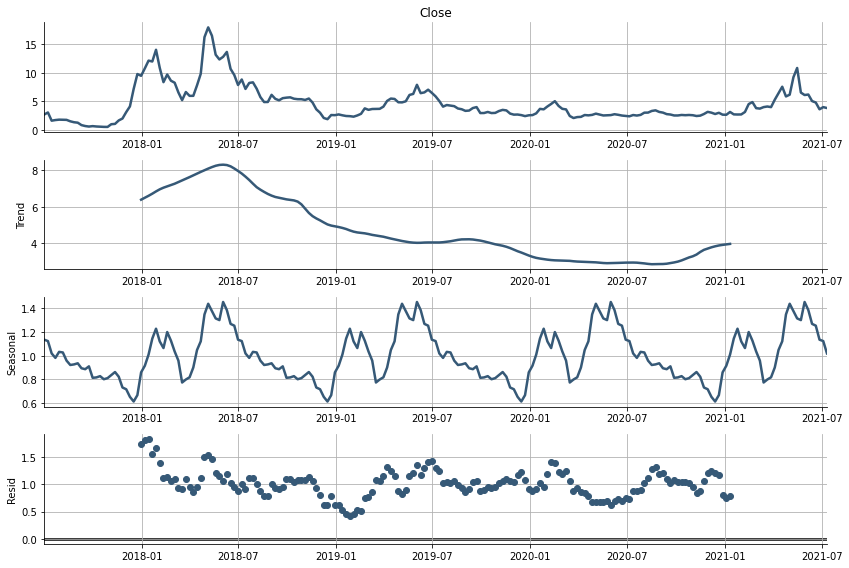

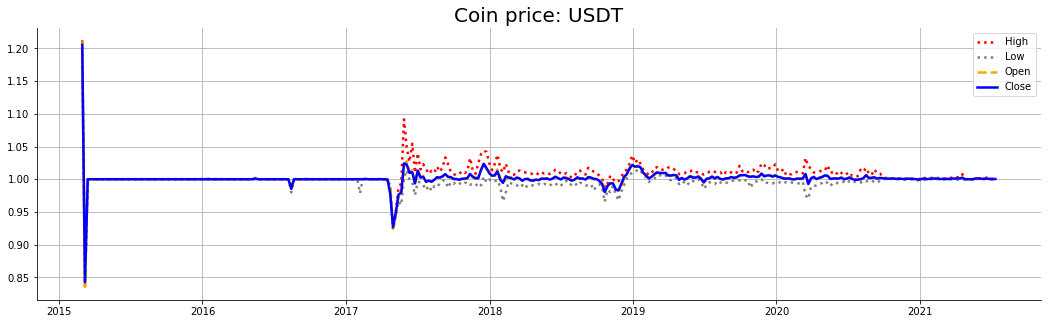

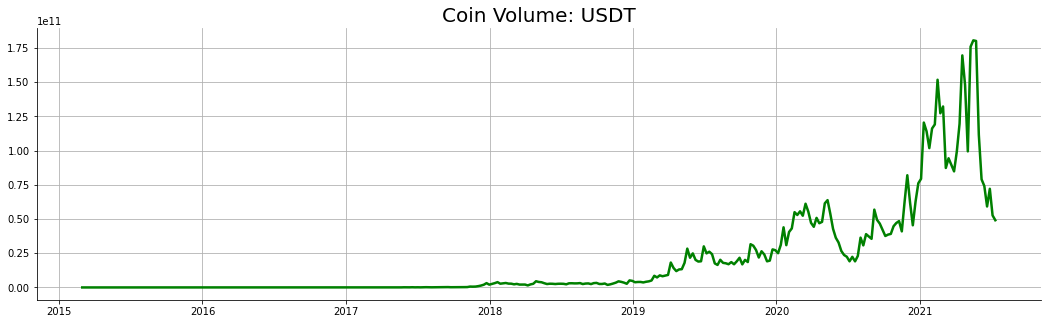

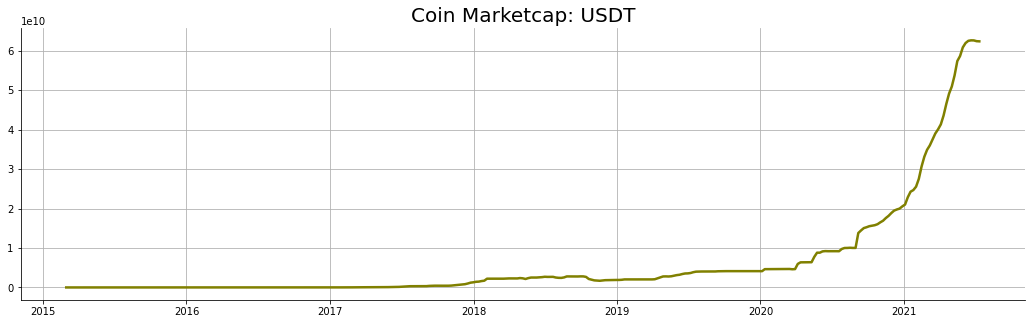

<Figure size 864x576 with 0 Axes>

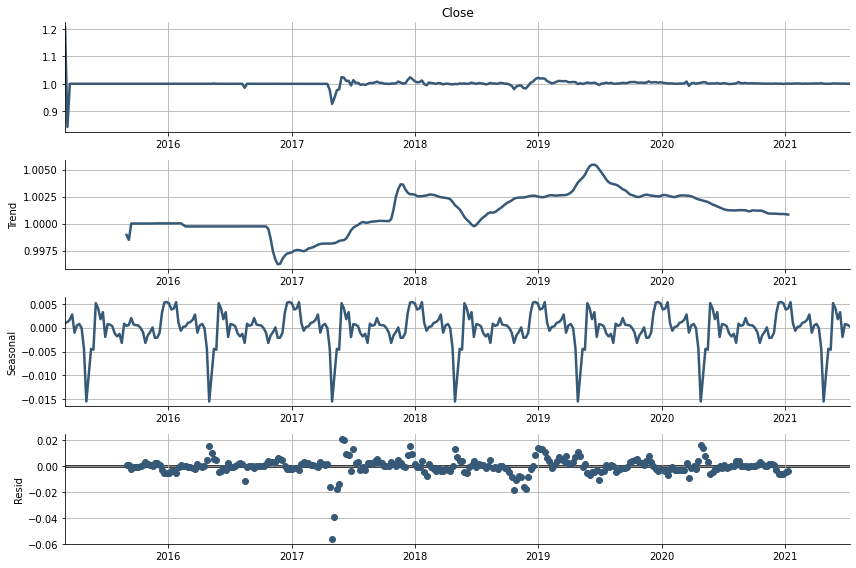

<Figure size 864x576 with 0 Axes>

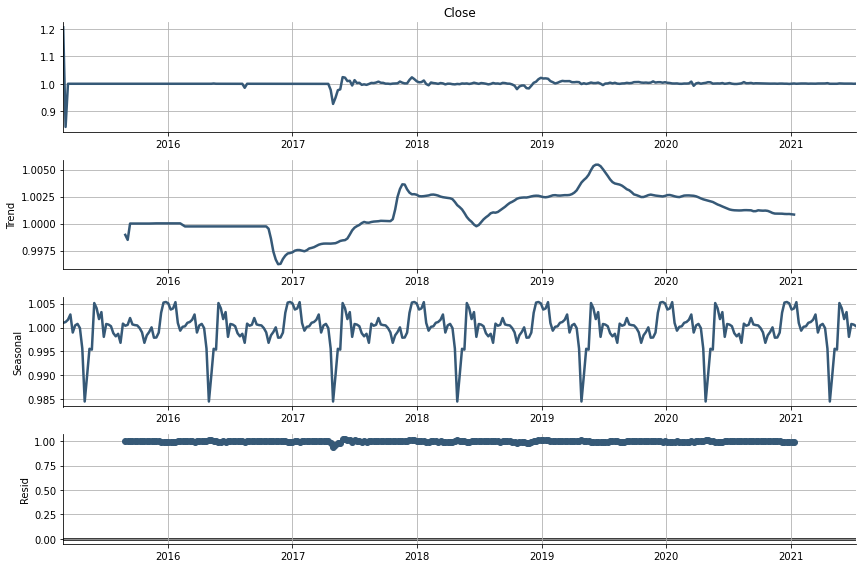

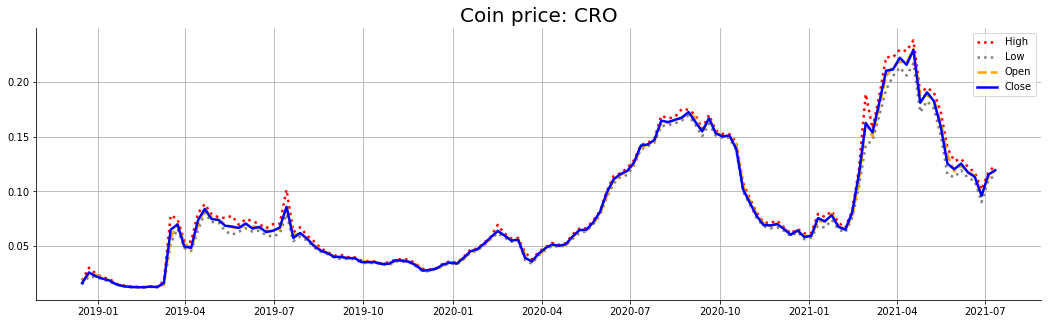

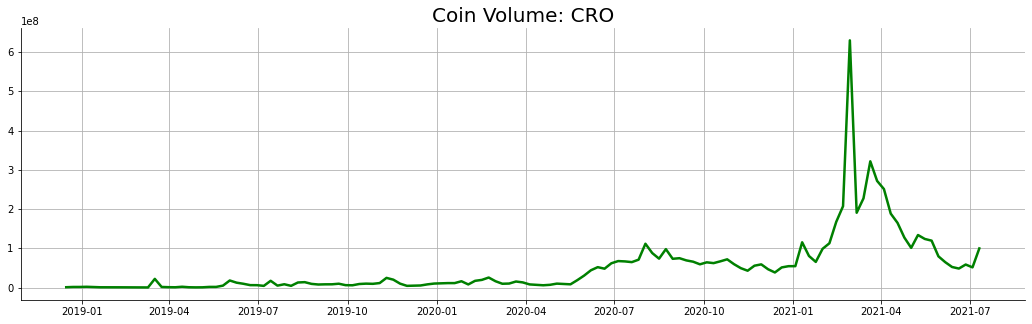

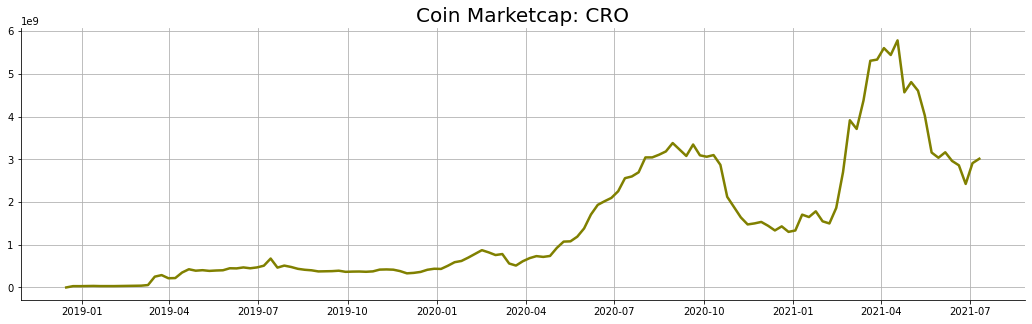

<Figure size 864x576 with 0 Axes>

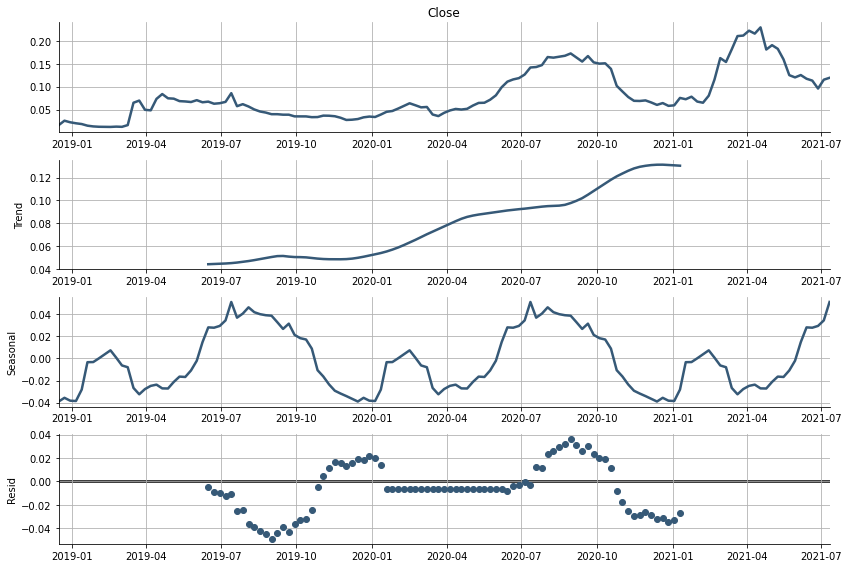

<Figure size 864x576 with 0 Axes>

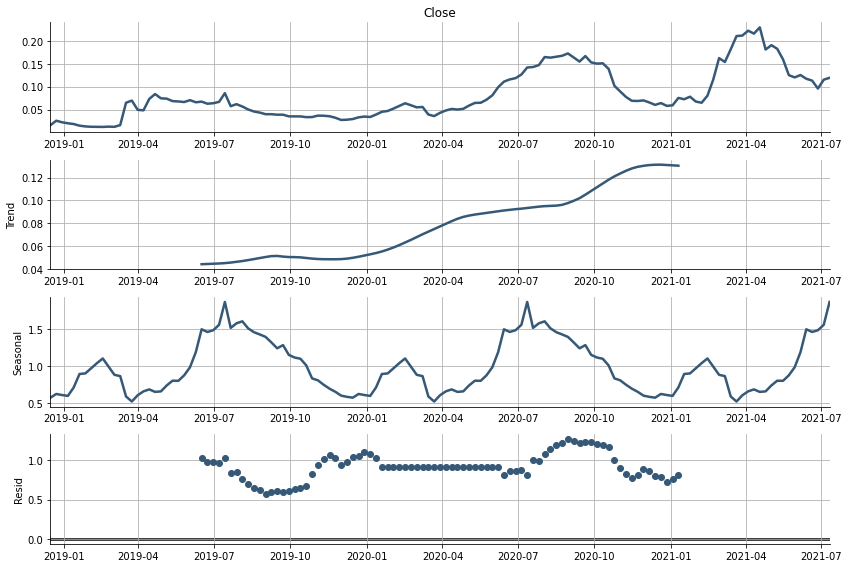

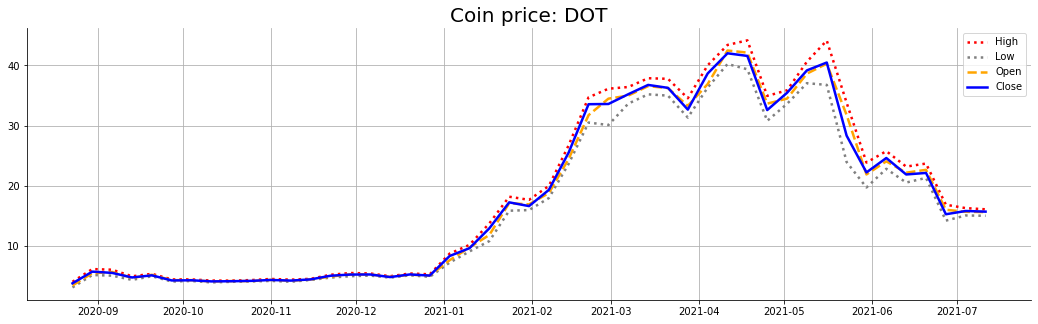

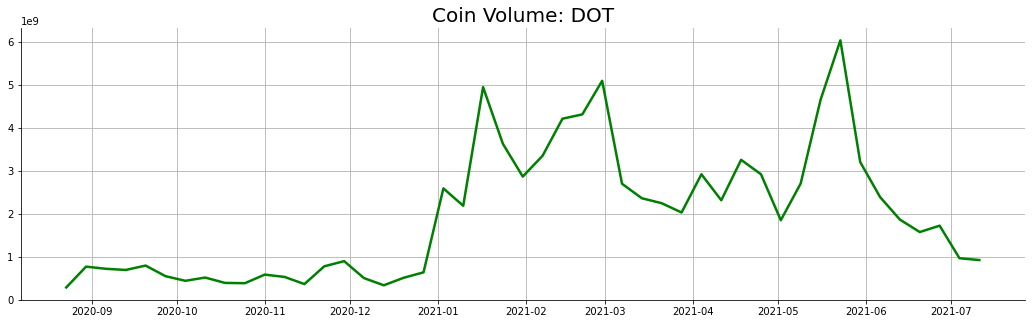

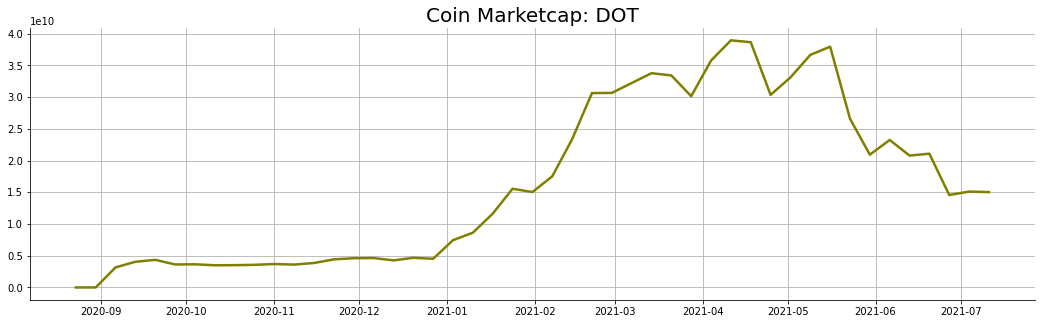

<Figure size 864x576 with 0 Axes>

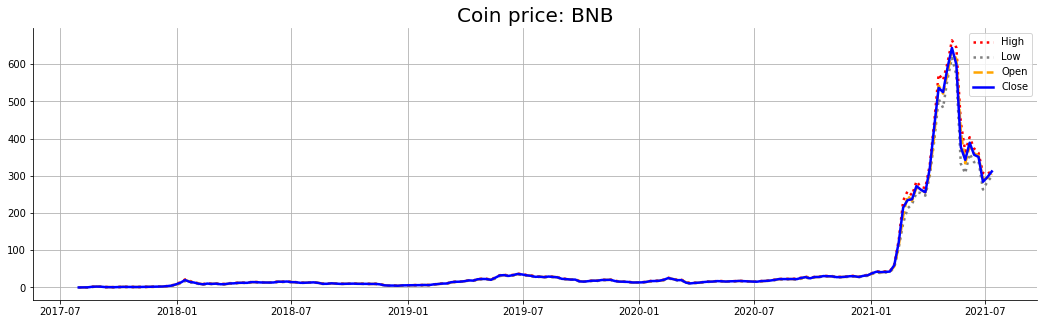

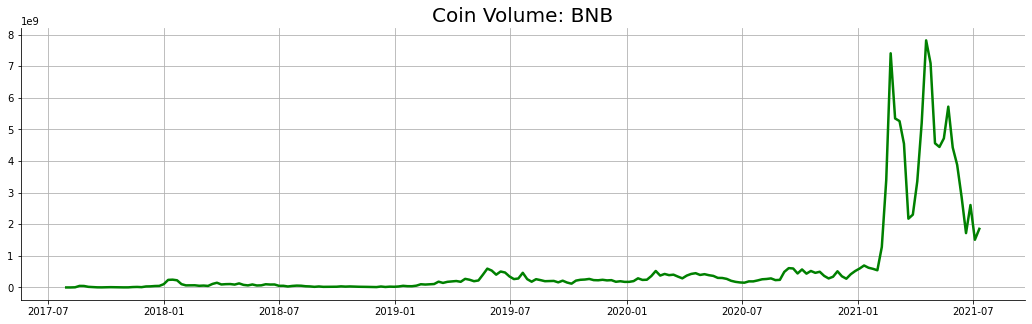

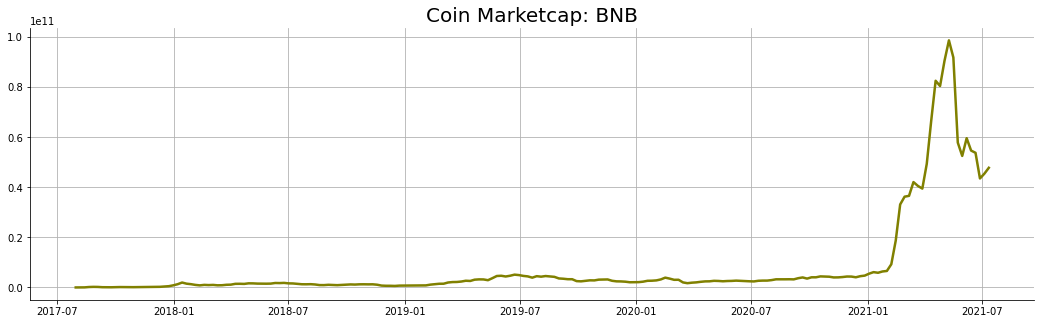

<Figure size 864x576 with 0 Axes>

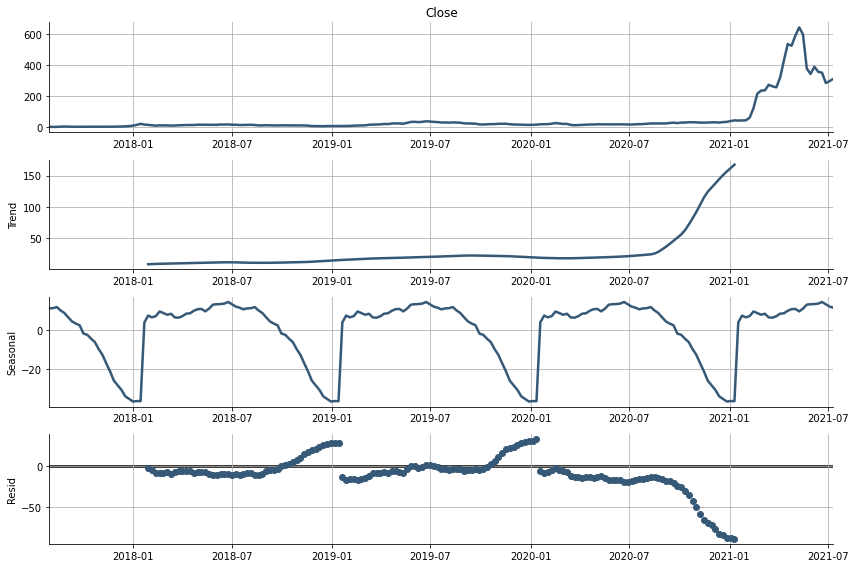

<Figure size 864x576 with 0 Axes>

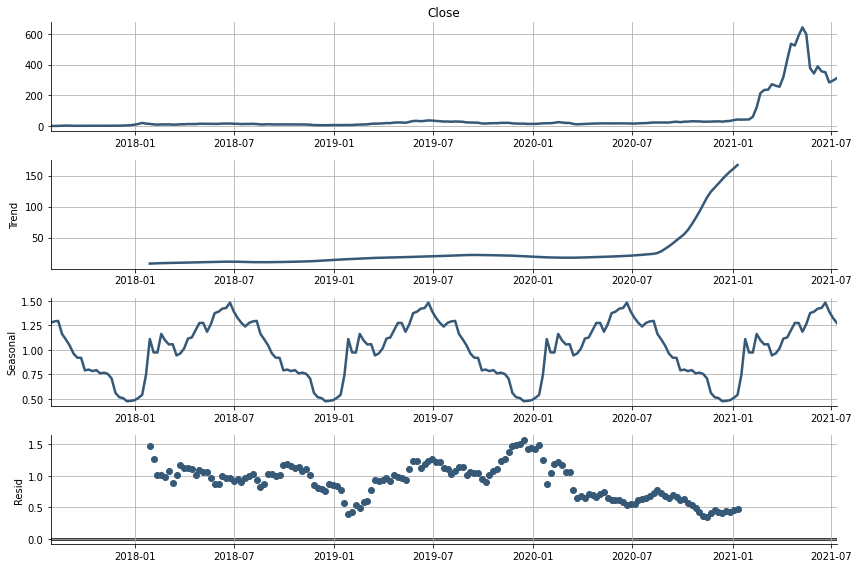

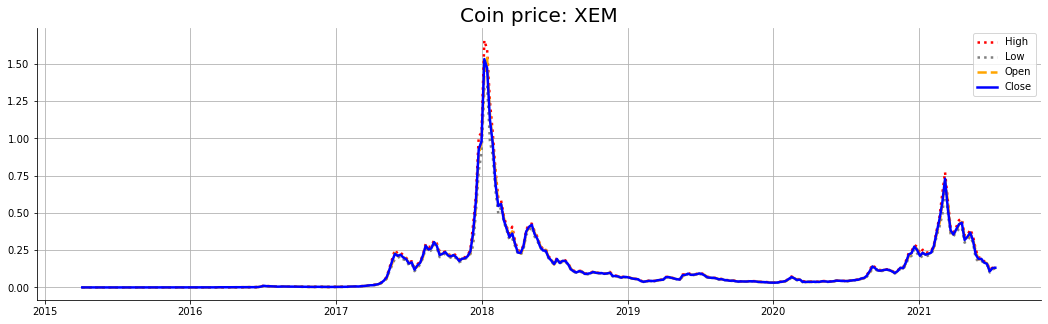

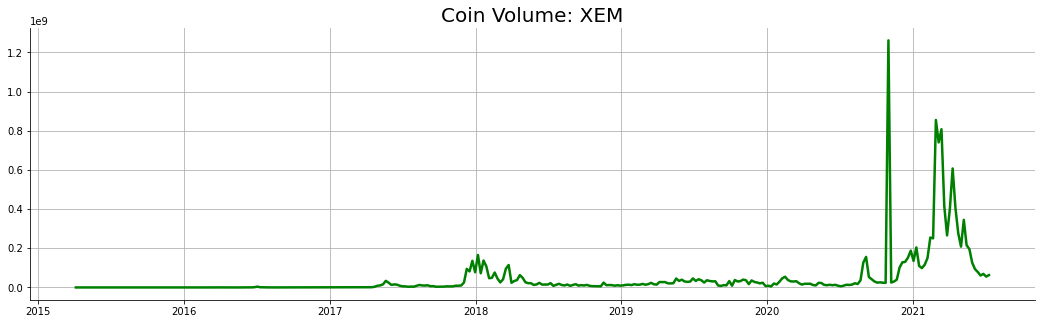

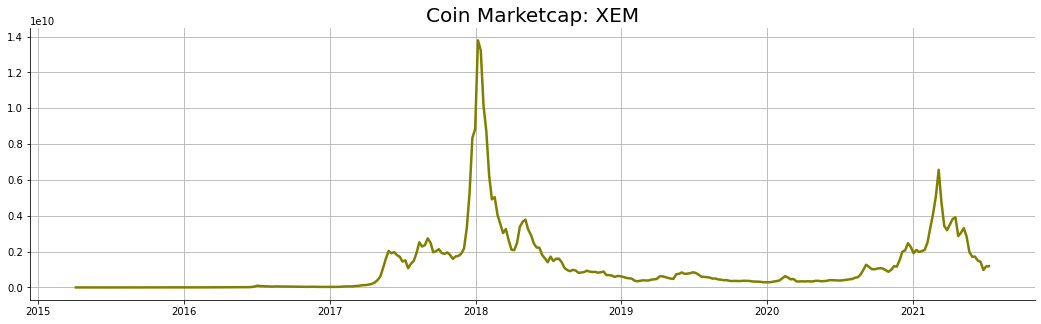

<Figure size 864x576 with 0 Axes>

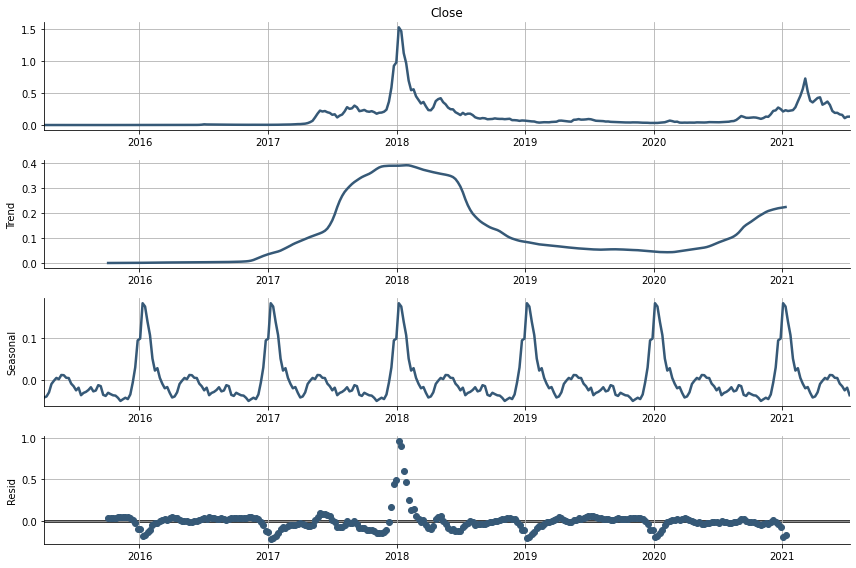

<Figure size 864x576 with 0 Axes>

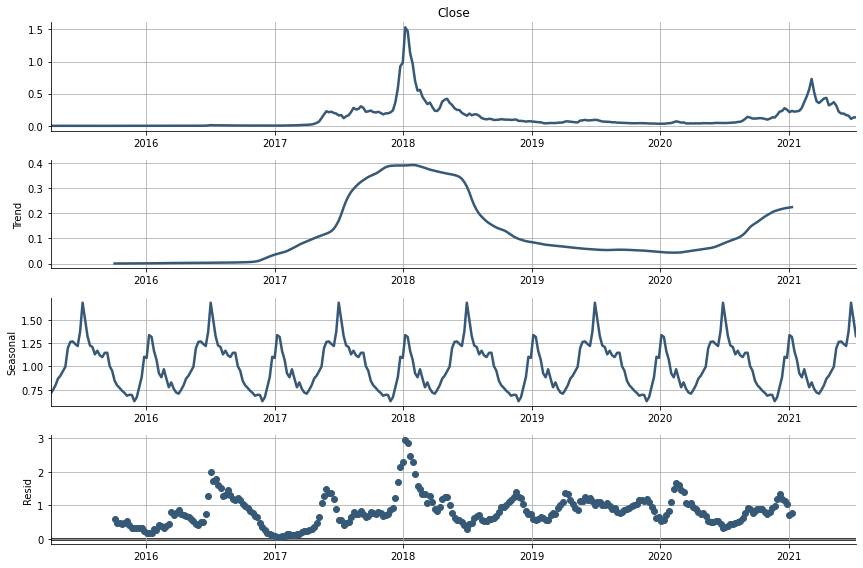

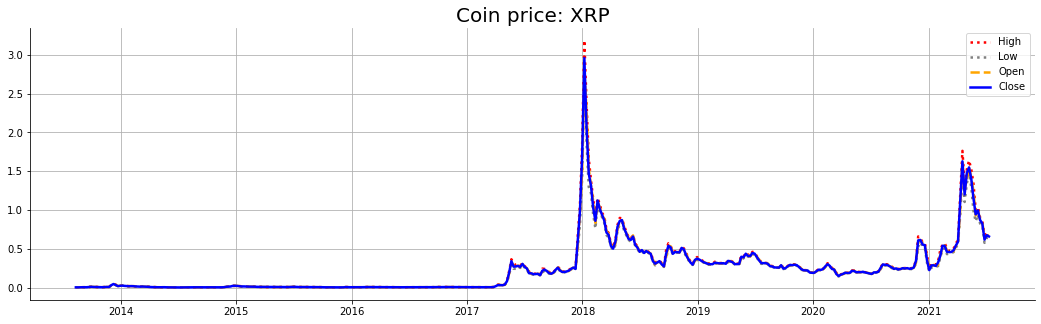

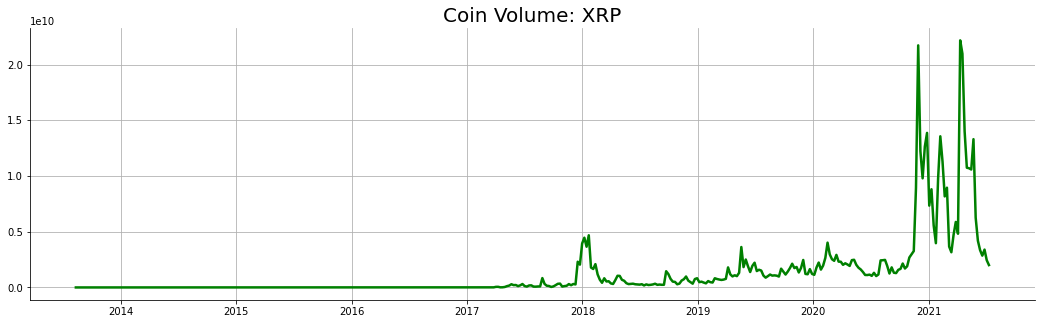

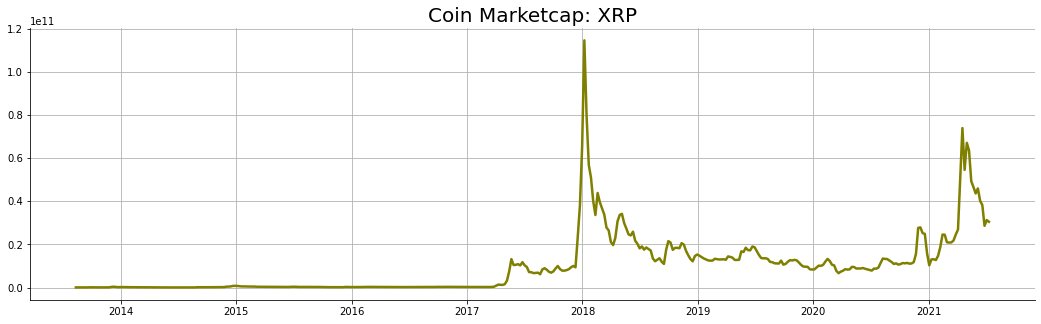

<Figure size 864x576 with 0 Axes>

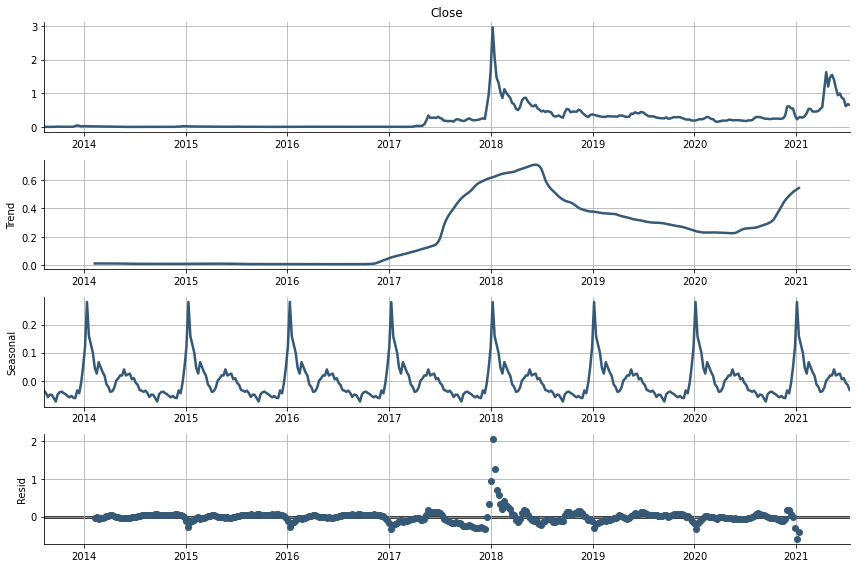

<Figure size 864x576 with 0 Axes>

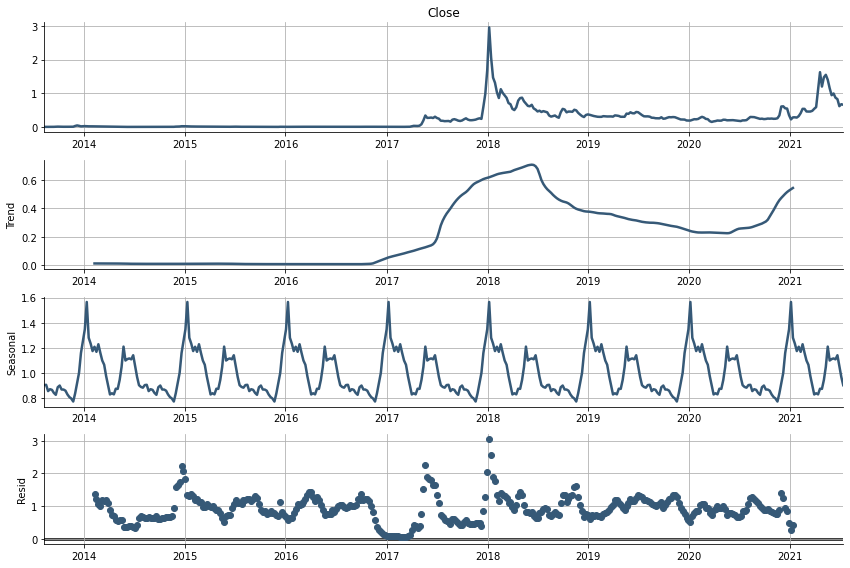

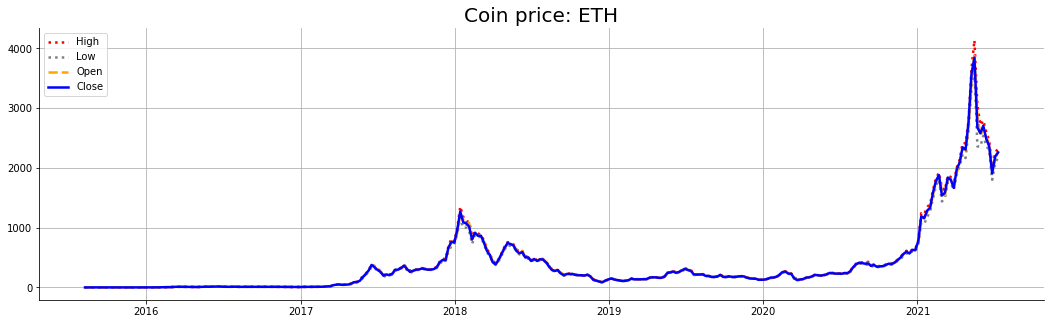

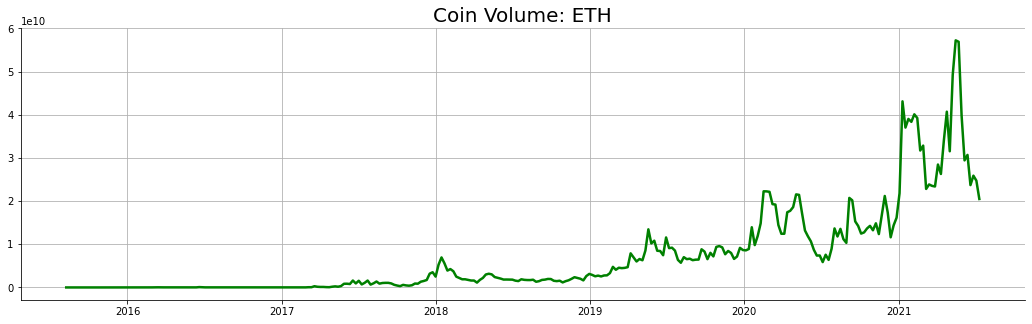

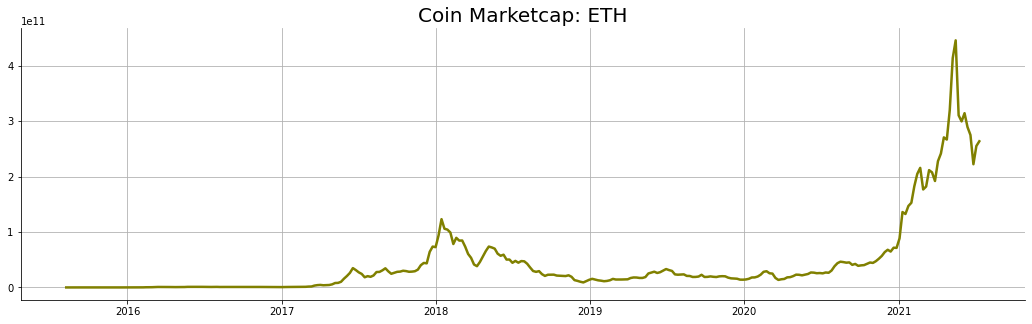

<Figure size 864x576 with 0 Axes>

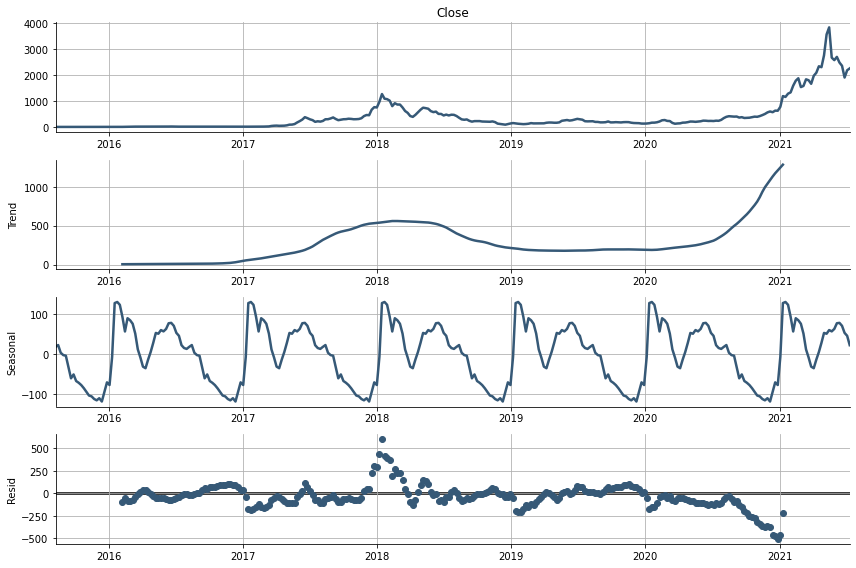

<Figure size 864x576 with 0 Axes>

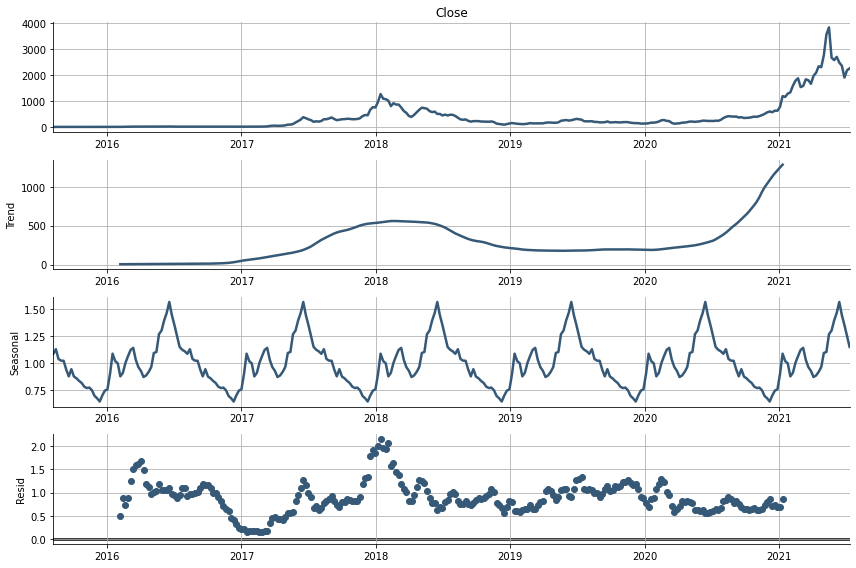

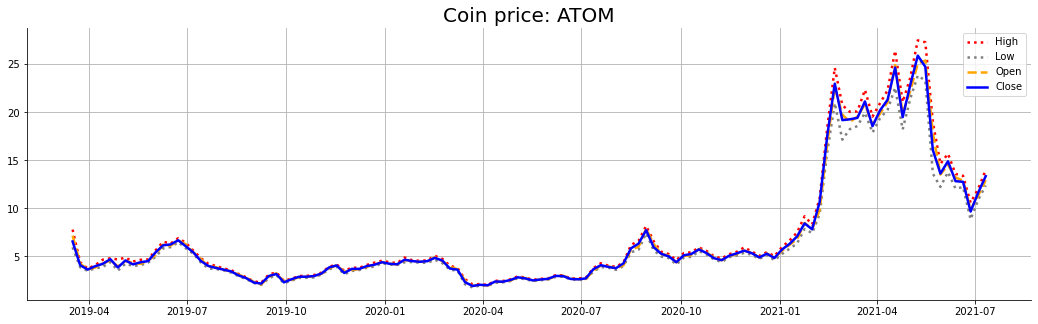

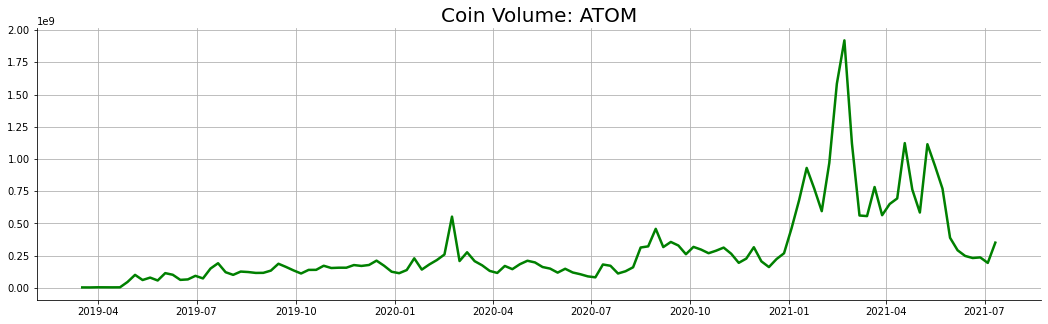

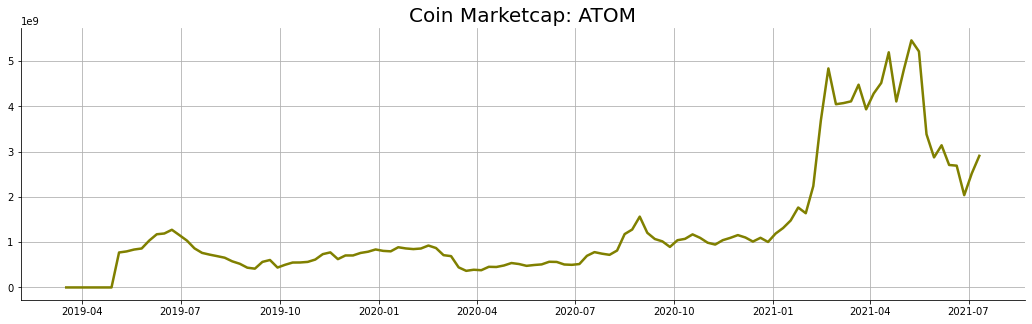

<Figure size 864x576 with 0 Axes>

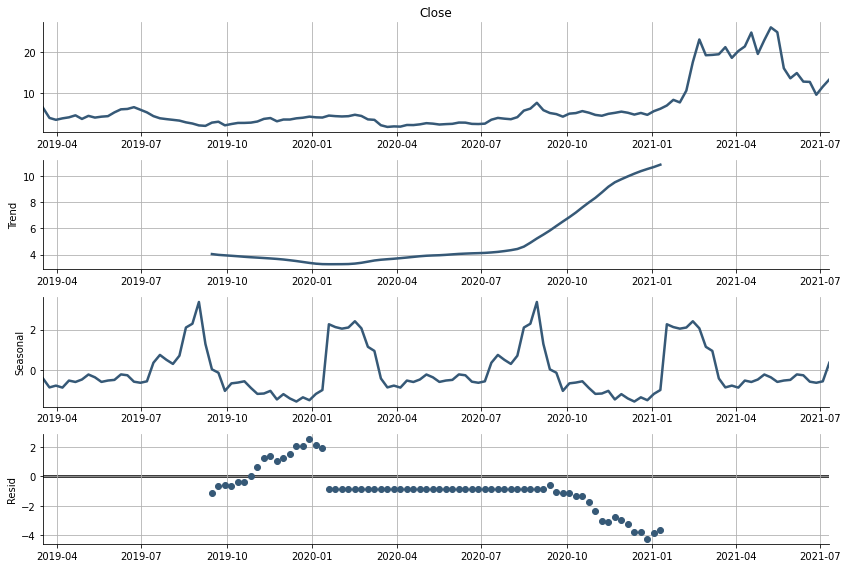

<Figure size 864x576 with 0 Axes>

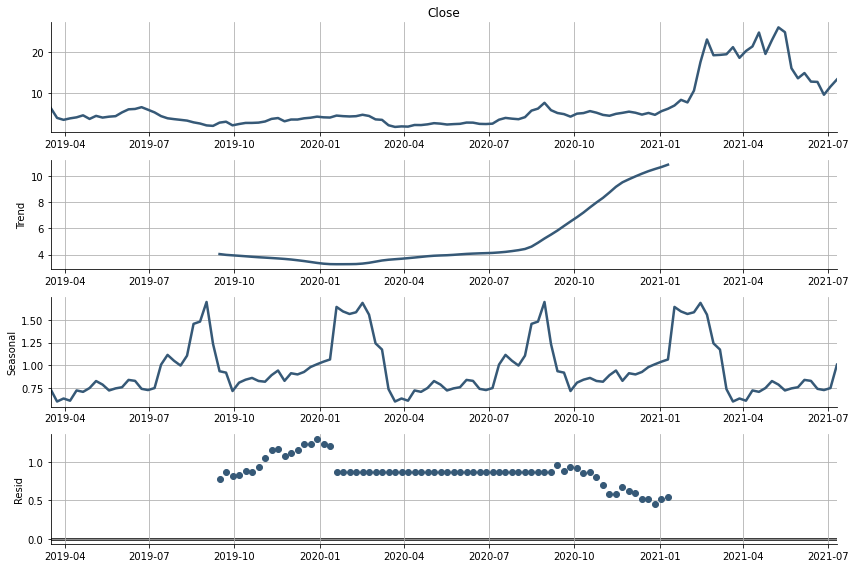

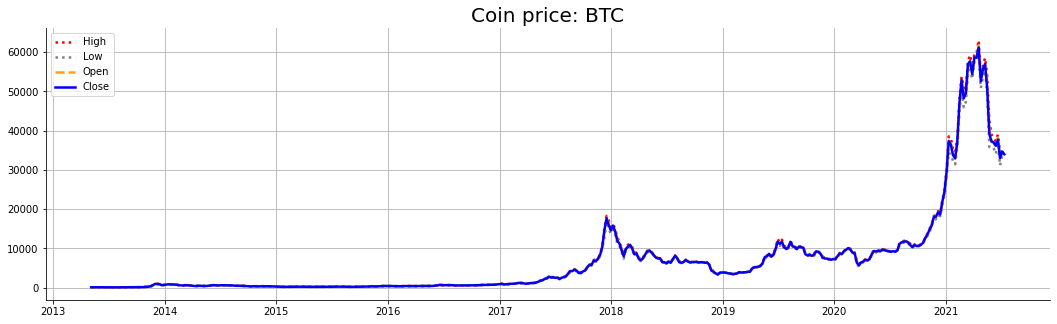

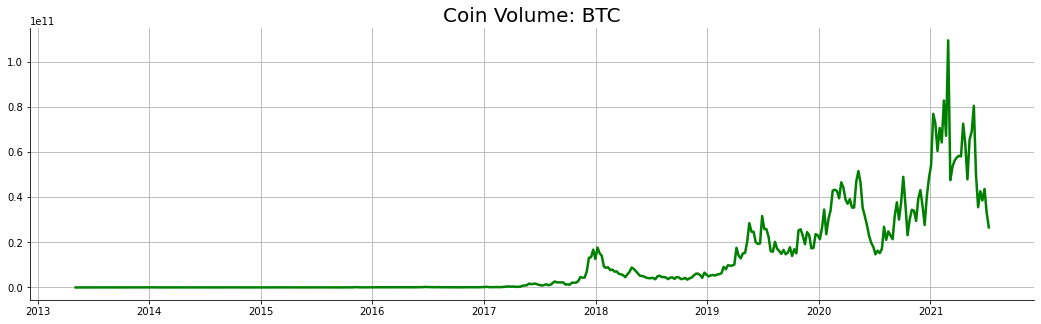

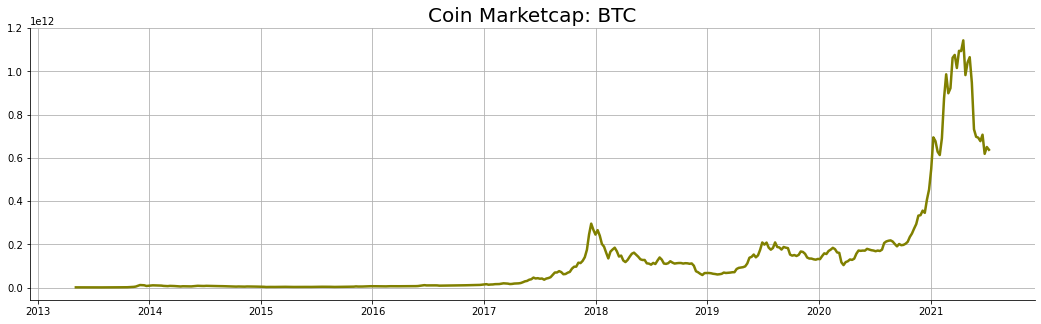

<Figure size 864x576 with 0 Axes>

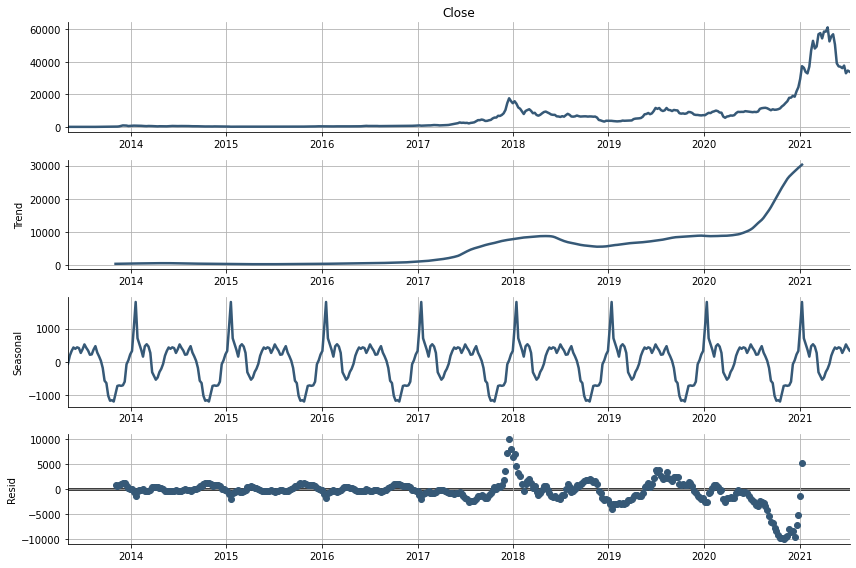

<Figure size 864x576 with 0 Axes>

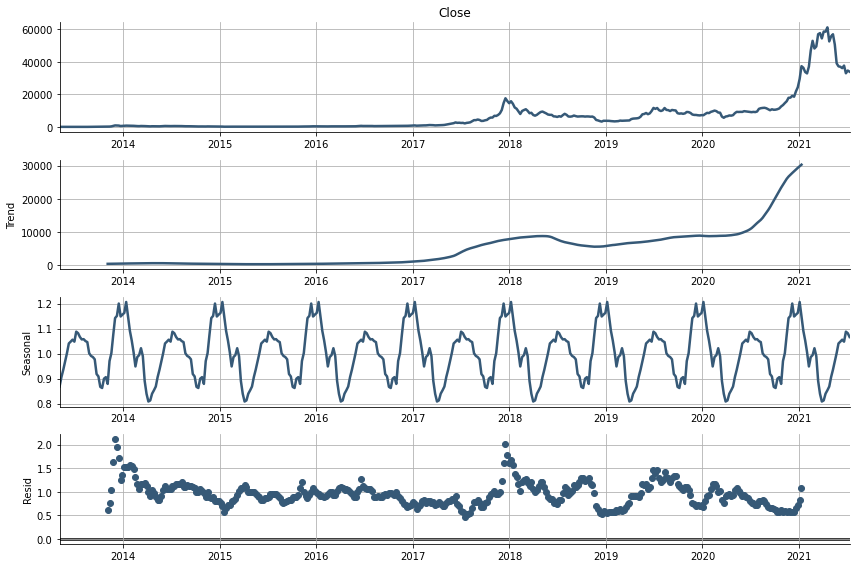

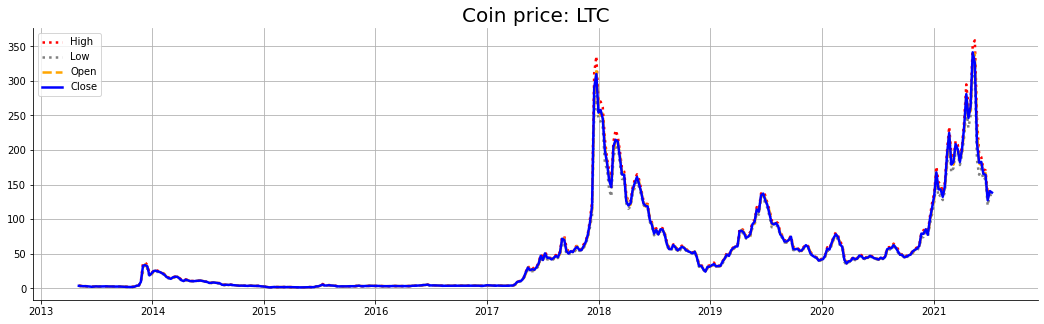

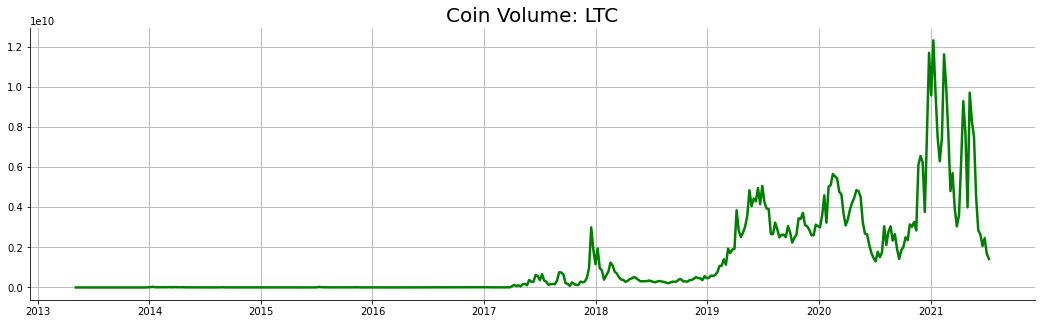

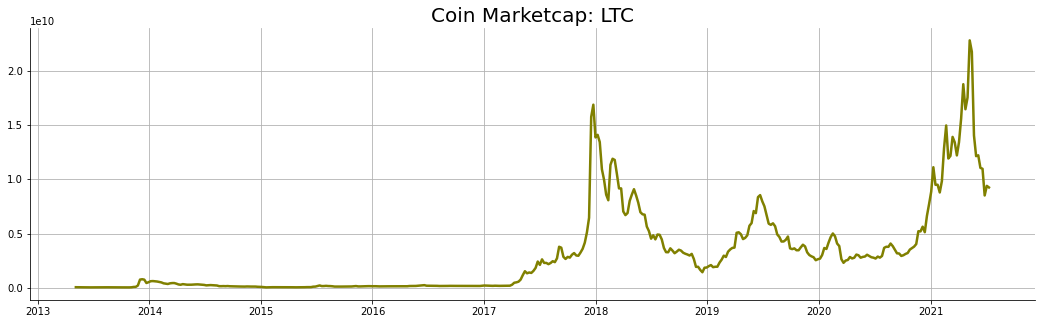

<Figure size 864x576 with 0 Axes>

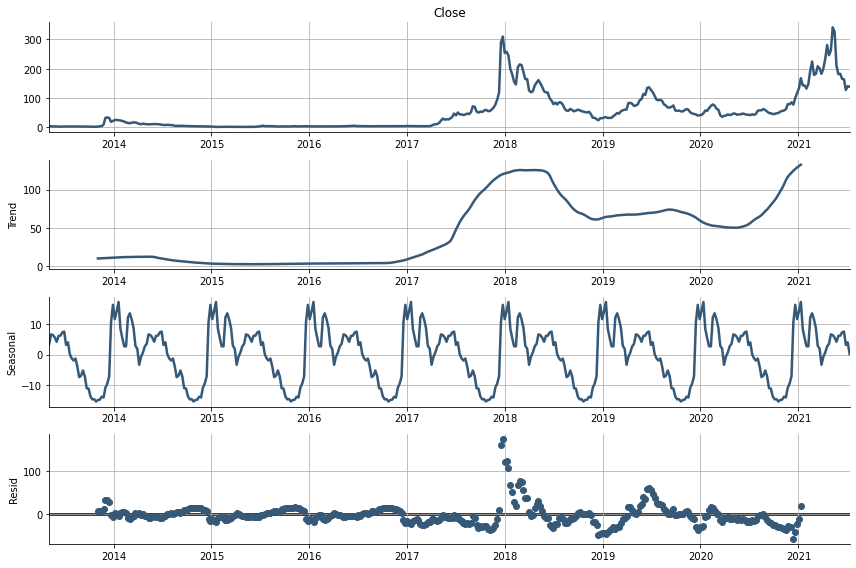

<Figure size 864x576 with 0 Axes>

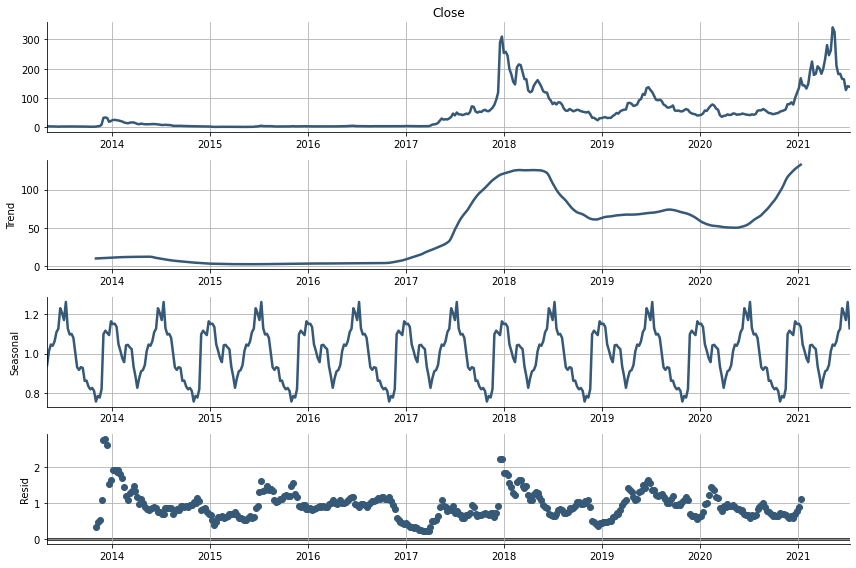

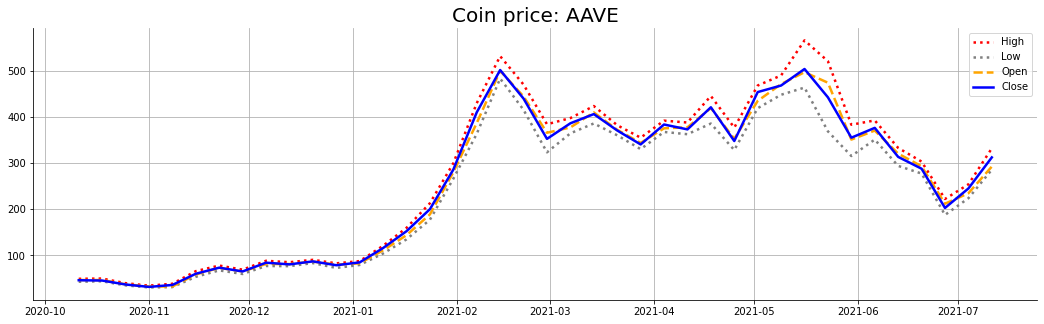

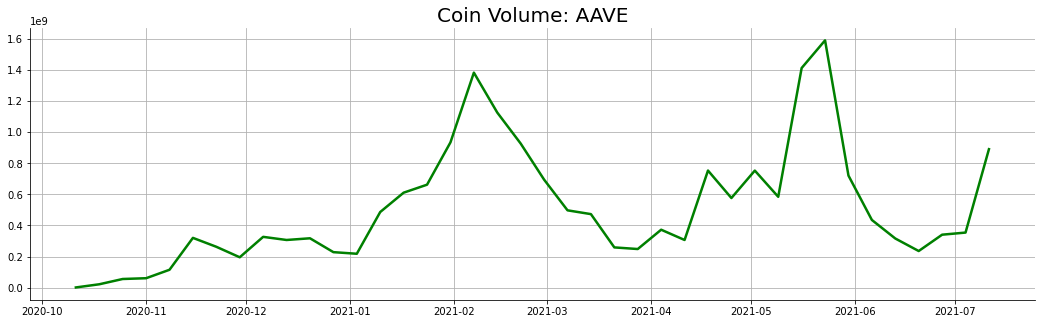

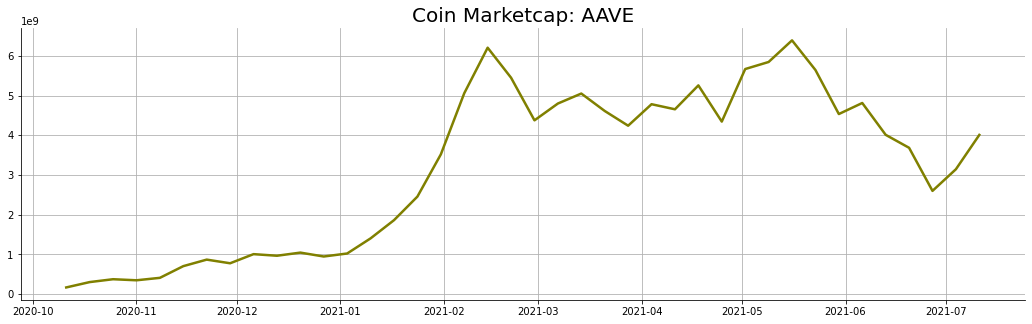

<Figure size 864x576 with 0 Axes>

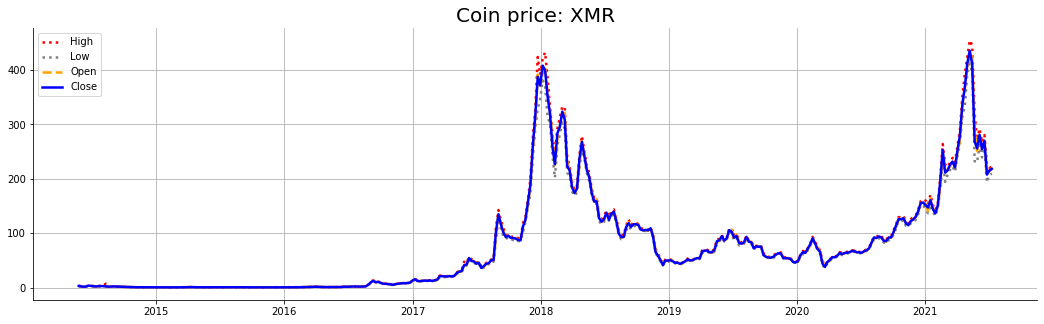

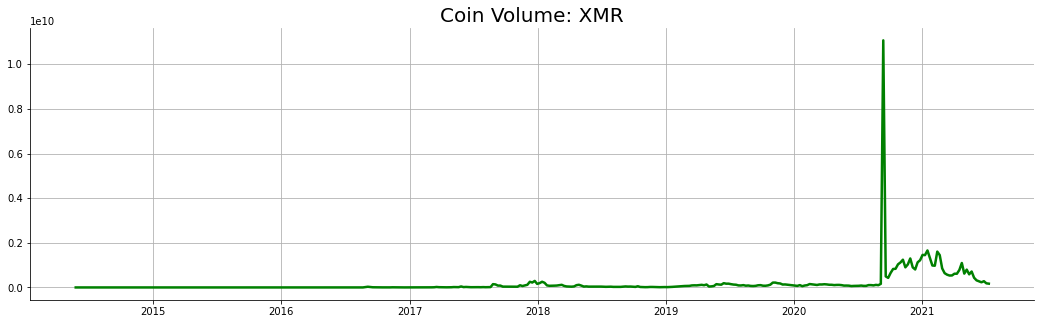

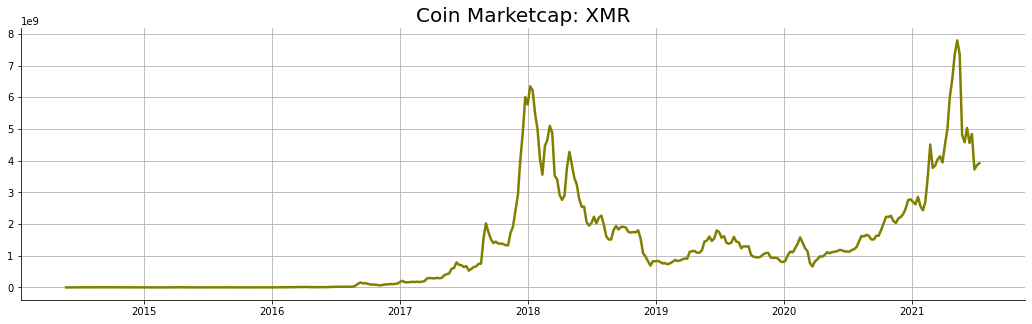

<Figure size 864x576 with 0 Axes>

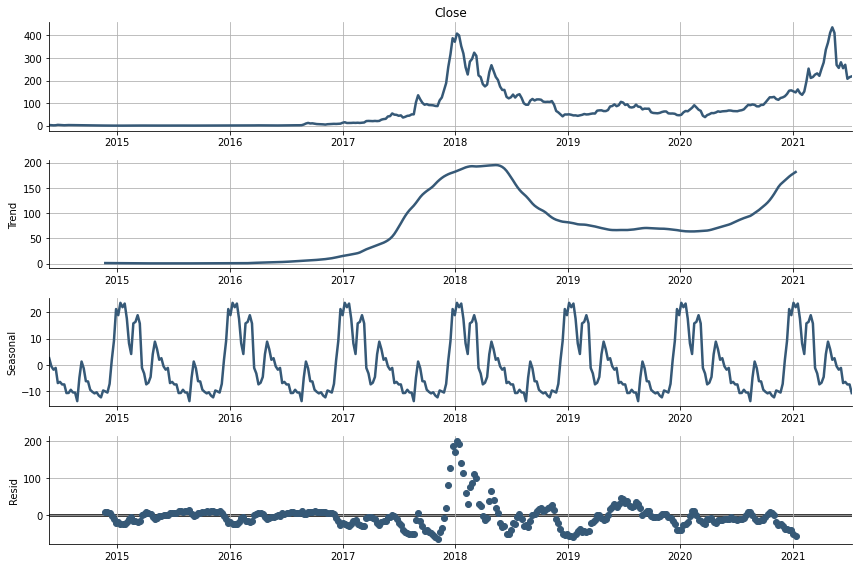

<Figure size 864x576 with 0 Axes>

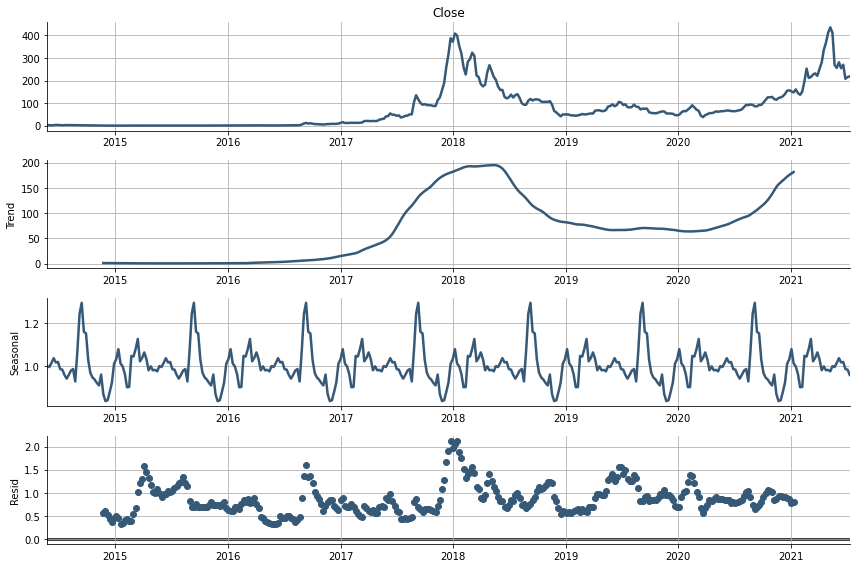

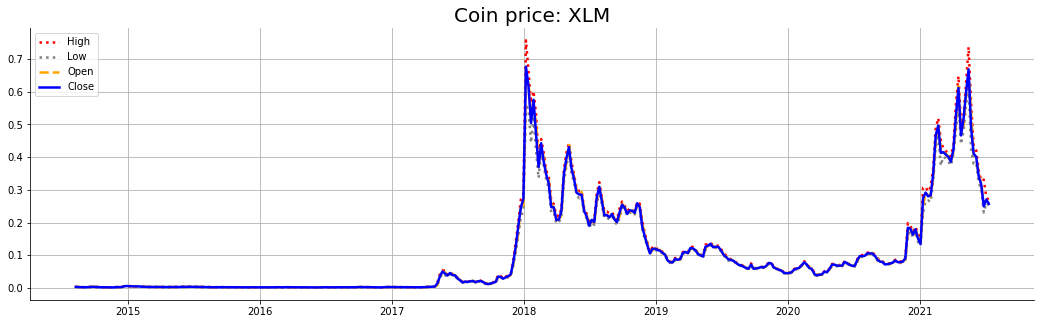

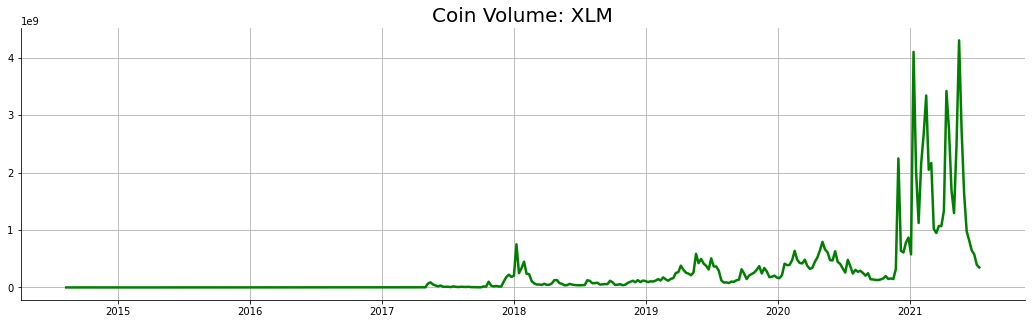

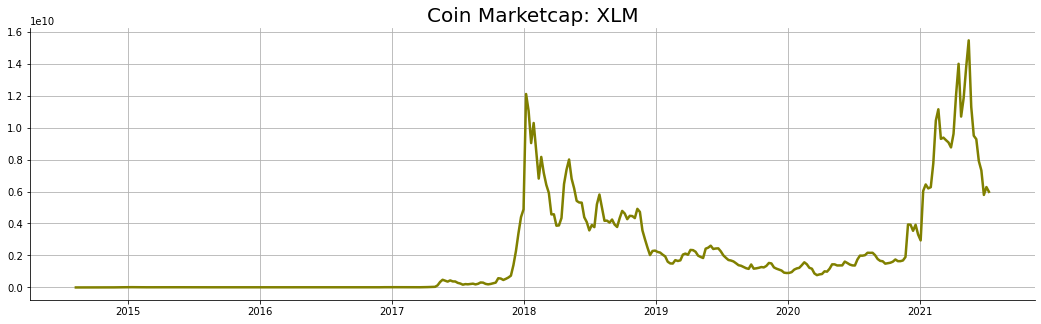

<Figure size 864x576 with 0 Axes>

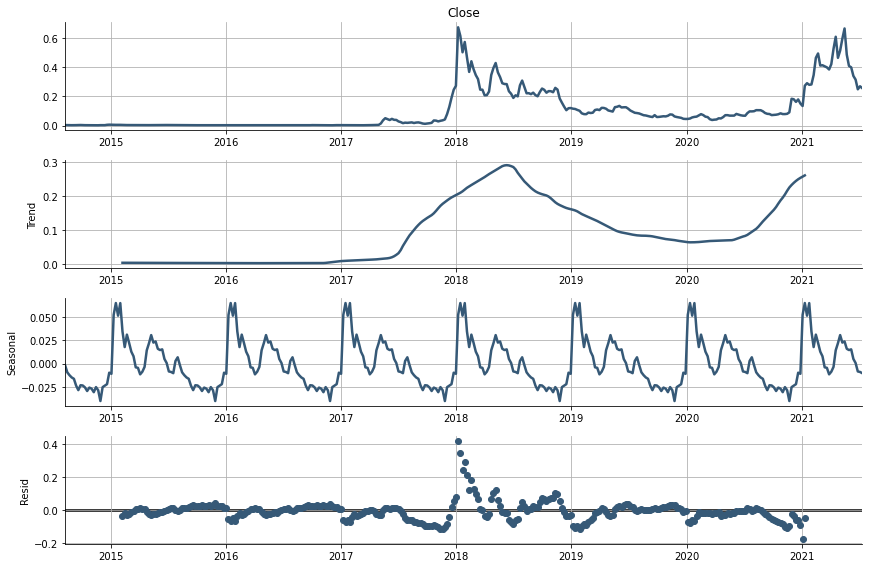

<Figure size 864x576 with 0 Axes>

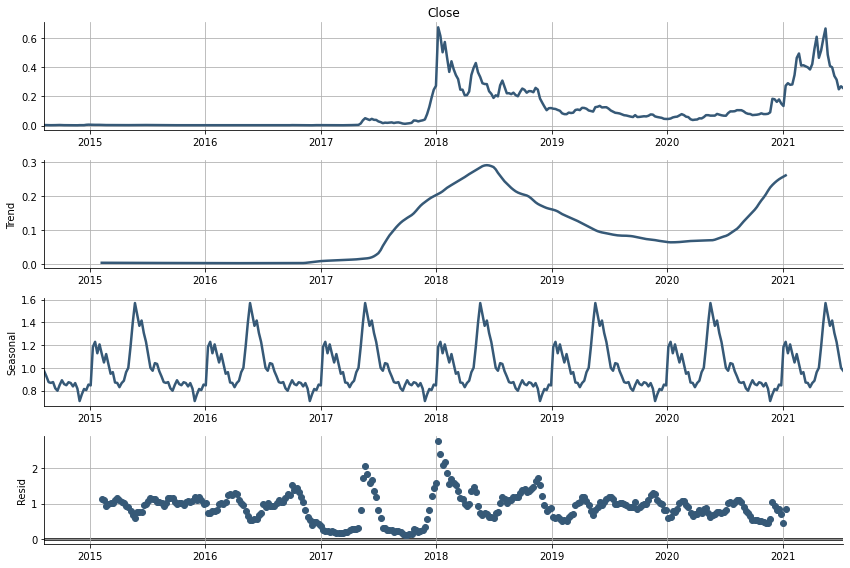

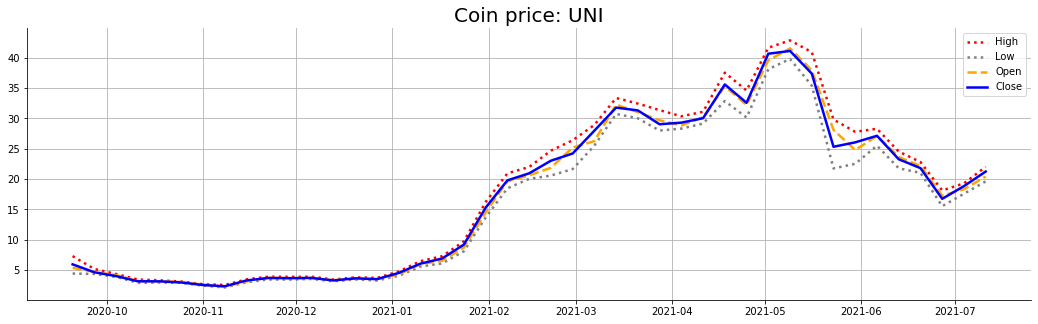

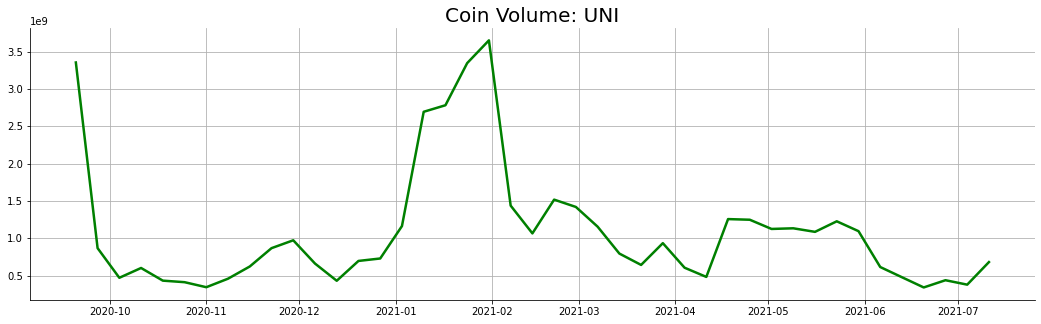

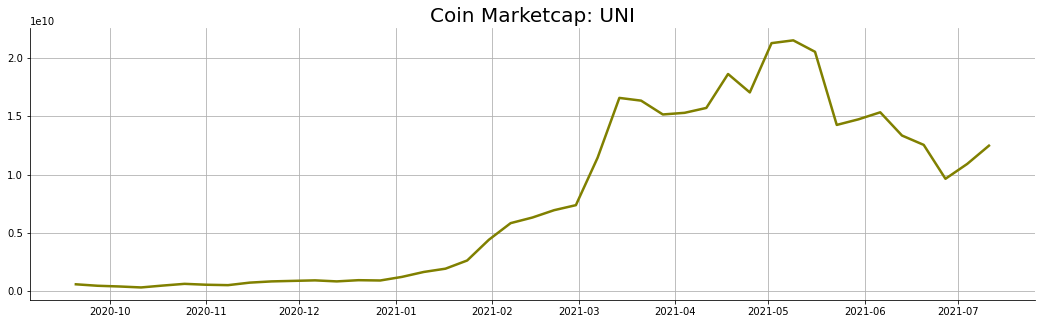

<Figure size 864x576 with 0 Axes>

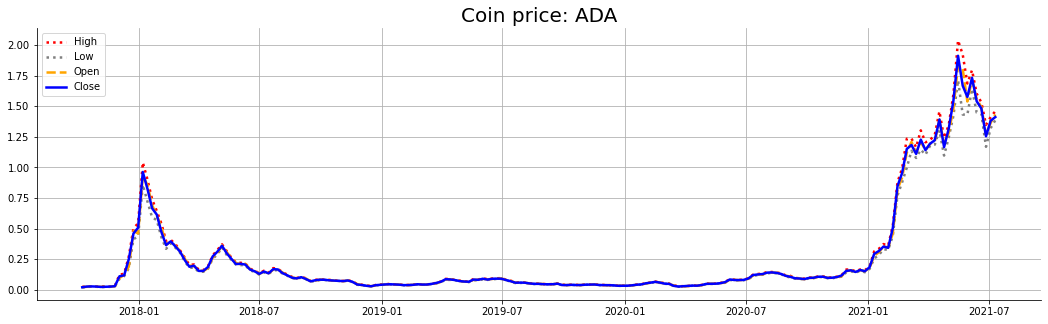

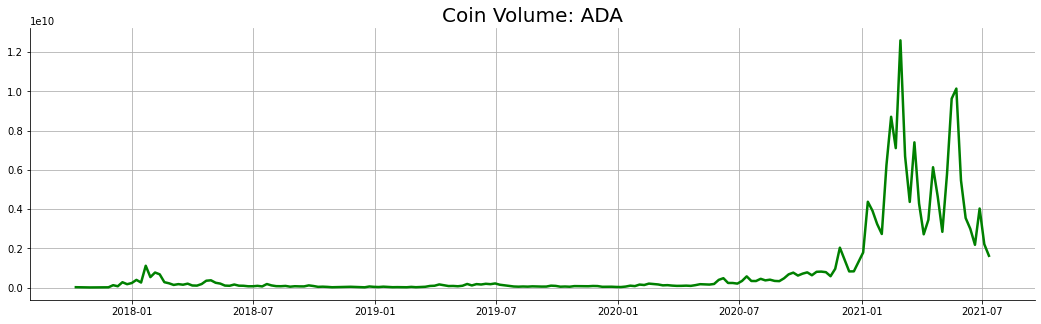

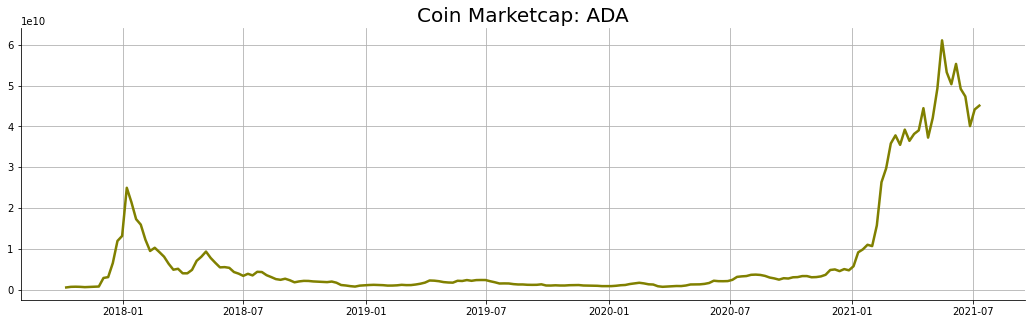

<Figure size 864x576 with 0 Axes>

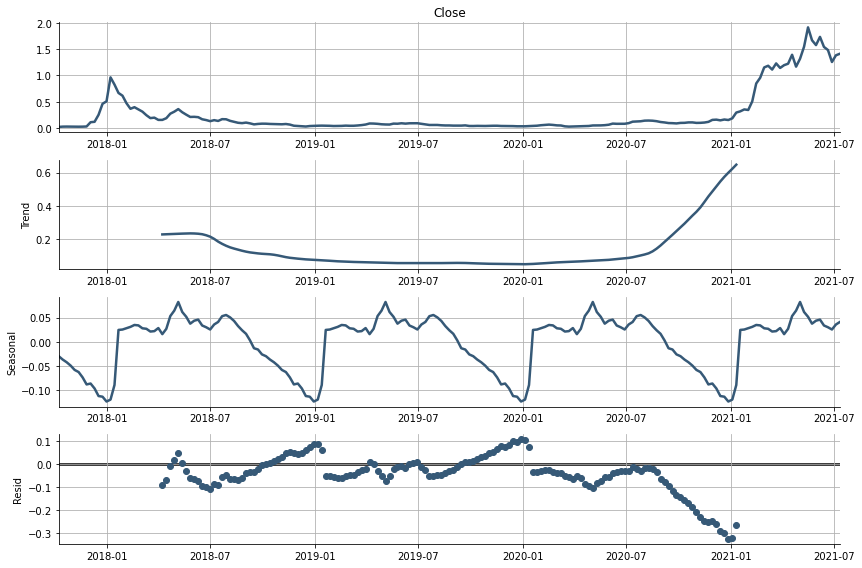

<Figure size 864x576 with 0 Axes>

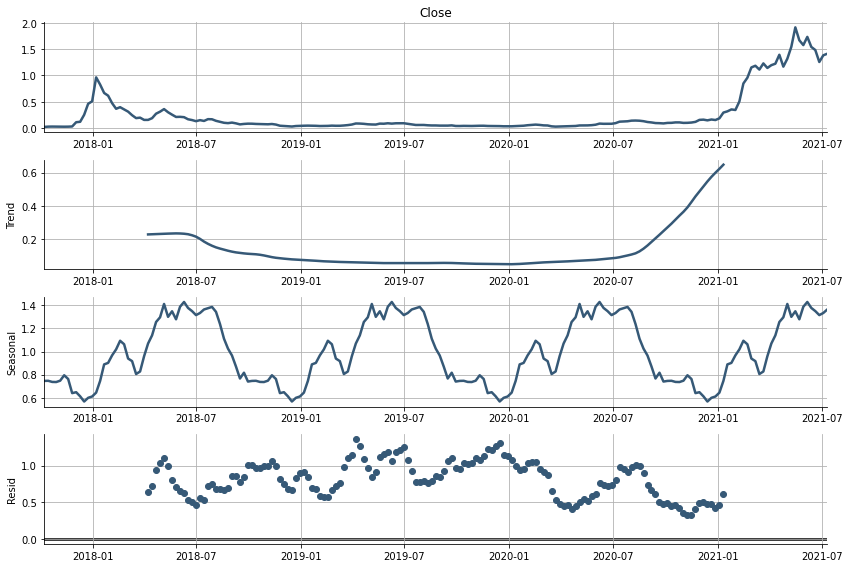

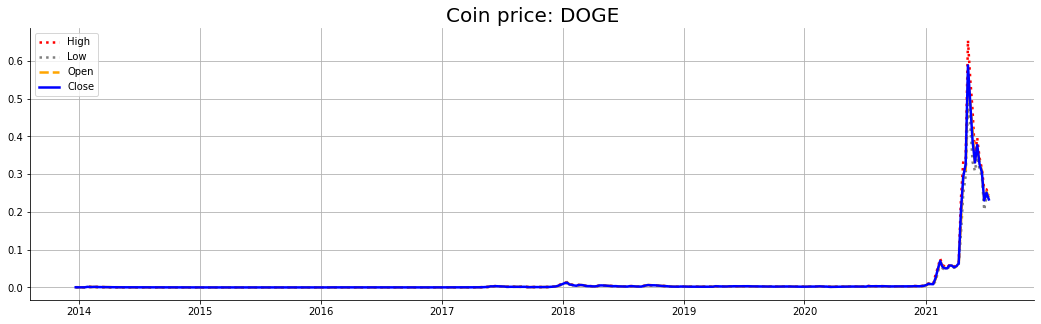

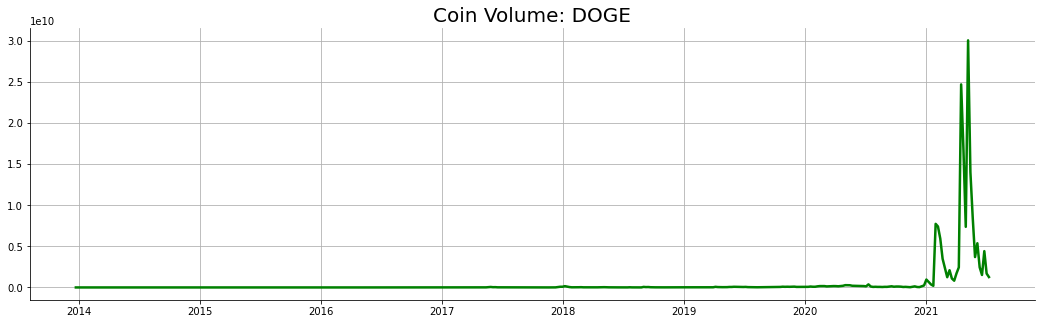

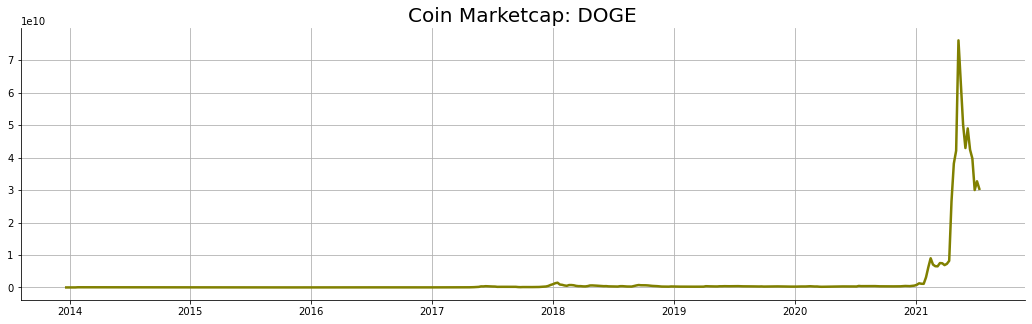

<Figure size 864x576 with 0 Axes>

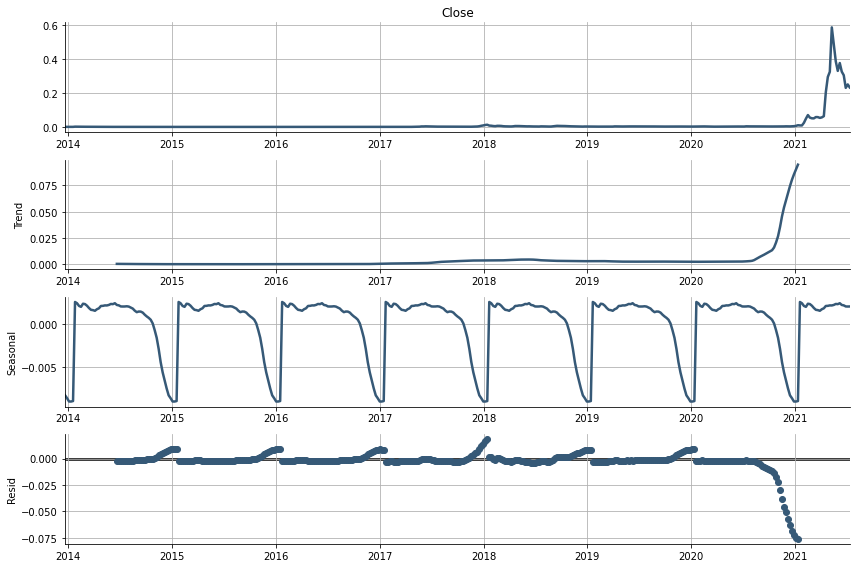

<Figure size 864x576 with 0 Axes>

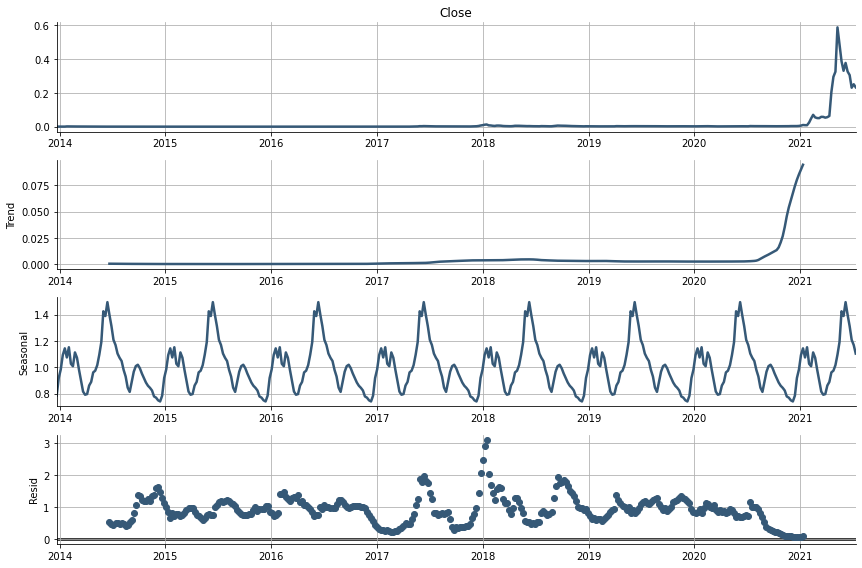

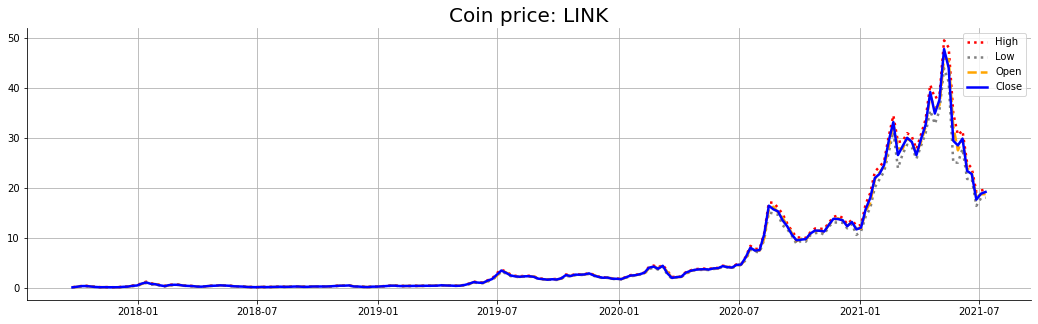

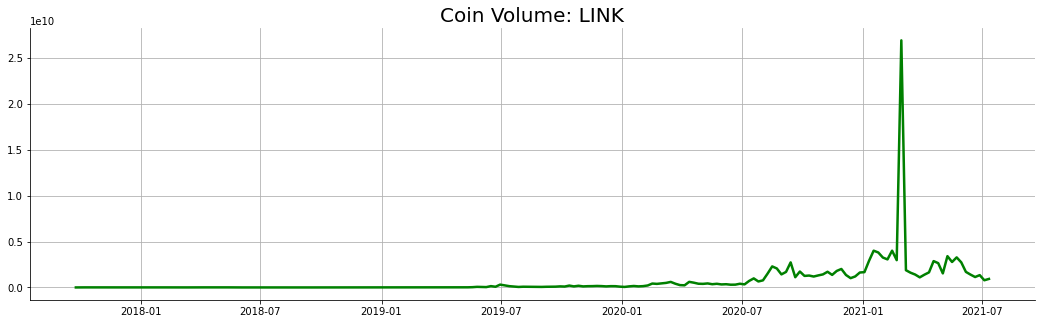

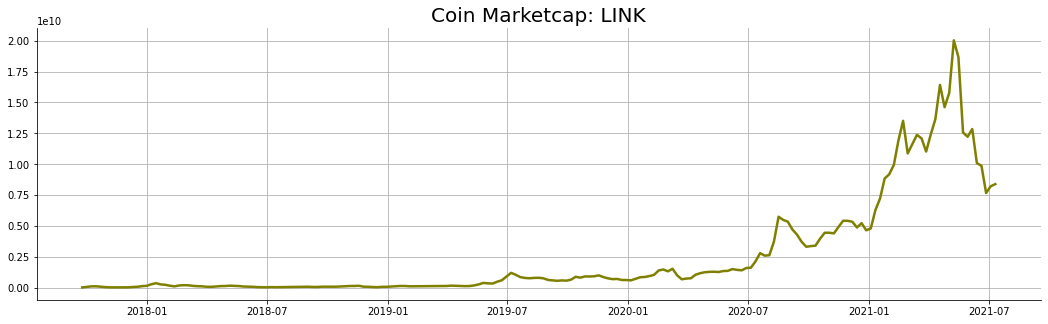

<Figure size 864x576 with 0 Axes>

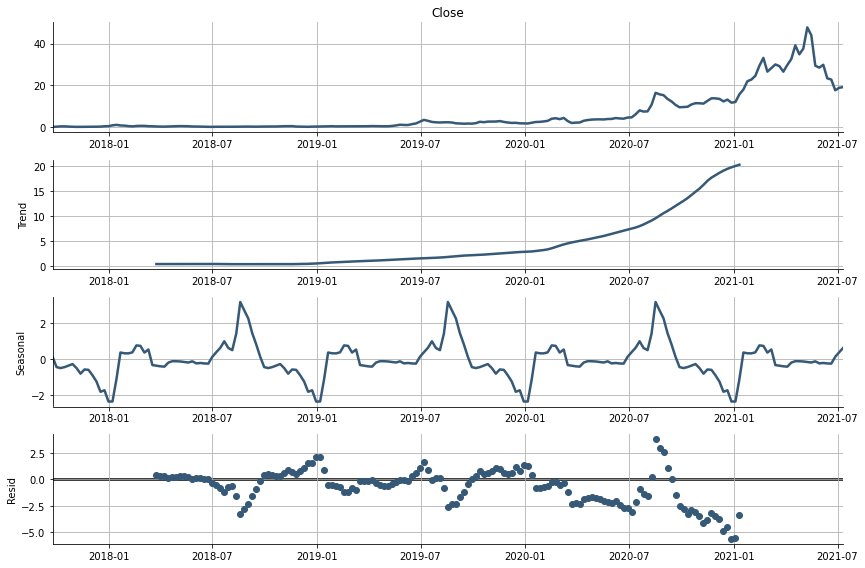

<Figure size 864x576 with 0 Axes>

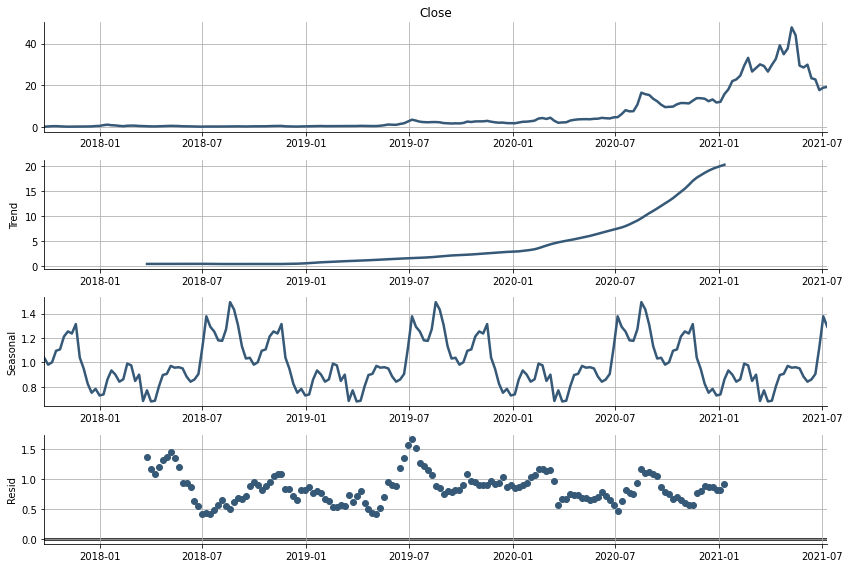

In [12]:
for coin in Coins:
    df_coin = df.query(f'Symbol == "{coin}"')[df.columns[3:]].set_index('Date').resample(rule='W').mean()
    rcParams['figure.figsize'] = 18, 5
    plt.figure()
    plt.title(f'Coin price: {coin}', size=20)
    for col in price_cols:
        plt.plot(df_coin[col], label=col, color=col2color[col], linestyle=linestyle[col])
    plt.legend()

    for col in other_cols:
        plt.figure()
        plt.title(f'Coin {col}: {coin}', size=20)
        plt.plot(df_coin[col], label=col, color=col2color[col], linestyle=linestyle[col])

    try:
        rcParams['figure.figsize'] = 12, 8
        for col in cols2decomposed:
            for model in modes2decomposed:
                plt.figure()
                decomposed = seasonal_decompose(df_coin[col], model=model)
                decomposed.plot();
    except ValueError as e:
        print(e)
    

In [13]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

Results = {
    'index': [],
    'sty_diff_order' : [],
    'r_y_energy_rel' : [],
    't_y_energy_rel' : [],
    's_y_energy_rel' : [],
    't_strength' : [],
    's_strength' : [],
    'spc_H' : [],
    'r_acf_energy' : [],
    'r_pacf_energy' : [],
    'model': []
}

col_target = 'Close'

for coin in tqdm(Coins):
    df_coin = df.query(f'Symbol == "{coin}"')[df.columns[3:]].set_index('Date').resample(rule='W').mean()
    spc_H = spectral_entropy(df_coin[col_target].to_numpy())
    Results['spc_H'].append(spc_H)
    Results['spc_H'].append(spc_H)
    Results['index'].append(coin)
    Results['index'].append(coin)
    
    for model in modes2decomposed:
        Results['model'].append(model)
        try:
            decomposed = seasonal_decompose(df_coin[col_target], model=model)
            Y = decomposed.observed.dropna().to_numpy()
            S = decomposed.seasonal.dropna().to_numpy()
            T = decomposed.trend.dropna().to_numpy()
            R = decomposed.resid.dropna().to_numpy()
        except ValueError:
            pass

        sty_diff_order = stationary_at_diff_order(Y)
        Results['sty_diff_order'].append(sty_diff_order)

        r_y_energy_rel = rel_energy(R,Y)
        Results['r_y_energy_rel'].append(r_y_energy_rel)

        t_y_energy_rel = rel_energy(T,Y)
        Results['t_y_energy_rel'].append(t_y_energy_rel)

        s_y_energy_rel = rel_energy(S,Y)
        Results['s_y_energy_rel'].append(s_y_energy_rel)

        t_strength = strength(T,R)
        Results['t_strength'].append(t_strength)

        N = (S.shape[0] - R.shape[0])//2        
        s_strength = strength(S[N:-N],R)
        Results['s_strength'].append(s_strength)

        try:
            r_acf_energy, r_pacf_energy = sum_acf_pacf(R)
        except ValueError:
            r_acf_energy, r_pacf_energy = np.nan, np.nan
            
        Results['r_acf_energy'].append(r_acf_energy)
        Results['r_pacf_energy'].append(r_pacf_energy)

            

100%|██████████| 23/23 [00:02<00:00,  8.47it/s]


In [14]:
df_results = pd.DataFrame.from_dict(Results)
md('# Results from automated analysis:')
display(df_results)
df_results.to_csv("/work/tmp/results_coin.csv", index=False)

# Results from automated analysis:

index  sty_diff_order  r_y_energy_rel  t_y_energy_rel  s_y_energy_rel  \
0   MIOTA               1        0.253155        0.638982        0.207894   
1   MIOTA               1        0.975794        0.638982        1.375038   
2    USDC               1        0.000791        0.638408        0.003378   
3    USDC               1        0.636341        0.638408        0.996345   
4     SOL               1        0.636341        0.638408        0.996345   
5     SOL               1        0.636341        0.638408        0.996345   
6    WBTC               1        0.109781        0.459921        0.103088   
7    WBTC               1        0.000031        0.459921        0.000059   
8     TRX               0        0.126989        0.611009        0.157289   
9     TRX               0       21.627982        0.611009       30.701757   
10    EOS               1        0.190431        0.770518        0.218056   
11    EOS               1        0.165515        0.770518        0.217033   
12   USDT               0        0.003334        0.843808        0.002442   
13   USDT               0        0.842880        0.843808        0.998859   
14    CRO               1        0.139921        0.591421        0.290895   
15    CRO               1        6.912587        0.591421       11.993568   
16    DOT               1        6.912587        0.591421       11.993568   
17    DOT               1        6.912587        0.591421       11.993568   
18    BNB               1        0.228229        0.379022        0.246996   
19    BNB               1        0.012835        0.379022        0.018820   
20    XEM               0        0.425587        0.829176        0.290803   
21    XEM               0        5.628050        0.829176        8.081468   
22    XRP               0        0.349687        0.807837        0.202548   
23    XRP               0        3.413221        0.807837        4.248187   
24    ETH               1        0.204091        0.609552        0.155500   
25    ETH               1        0.001916        0.609552        0.002580   
26   ATOM               1        0.115435        0.430681        0.140057   
27   ATOM               1        0.073593        0.430681        0.141591   
28    BTC               1        0.186615        0.650371        0.072226   
29    BTC               1        0.000124        0.650371        0.000148   
30    LTC               0        0.283758        0.783682        0.156604   
31    LTC               0        0.016611        0.783682        0.020295   
32   AAVE               0        0.016611        0.783682        0.020295   
33   AAVE               0        0.016611        0.783682        0.020295   
34    XMR               1        0.252661        0.785359        0.123229   
35    XMR               1        0.010026        0.785359        0.013459   
36    XLM               1        0.324929        0.756643        0.202232   
37    XLM               1        7.562715        0.756643        9.827027   
38    UNI               1        7.562715        0.756643        9.827027   
39    UNI               1        7.562715        0.756643        9.827027   
40    ADA               2        0.190166        0.378851        0.184948   
41    ADA               2        2.303573        0.378851        3.826431   
42   DOGE               3        0.291541        0.248992        0.199206   
43   DOGE               3       55.493964        0.248992       71.006199   
44   LINK               0        0.151968        0.483337        0.110341   
45   LINK               0        0.098655        0.483337        0.155878   

    t_strength  s_strength     spc_H  r_acf_energy  r_pacf_energy  \
0     0.643149    0.174798  0.519886      5.674886       4.401336   
1     0.728507    0.217932  0.519886      5.988207       4.308760   
2     0.404224    0.895131  0.652492      6.868832       7.394259   
3     0.407075    0.895294  0.652492      6.872003       7.385872   
4     0.407075    0.895294  0.370972   

In [139]:
for col in df_results.columns:
    md(f'## {col}')
    md(f'### Head')
    display(df_results.sort_values(col).head(5))
    md(f'### Tail')
    display(df_results.sort_values(col).tail(5))

## index

### Head

index  sty_diff_order  r_y_energy_rel  t_y_energy_rel  s_y_energy_rel  \
33  AAVE               0        0.016611        0.783682        0.020295   
32  AAVE               0        0.016611        0.783682        0.020295   
41   ADA               2        2.303573        0.378851        3.826431   
40   ADA               2        0.190166        0.378851        0.184948   
27  ATOM               1        0.073593        0.430681        0.141591   

    t_strength  s_strength     spc_H  r_acf_energy  r_pacf_energy  \
33    0.999917    0.107503  0.278996      9.202324       3.553434   
32    0.999917    0.107503  0.278996      9.202324       3.553434   
41    0.000000    0.563368  0.491434     11.484328       6.394330   
40    0.000000    0.308648  0.491434      9.392298       4.565319   
27    0.993599    0.703752  0.389102           NaN            NaN   

             model  
33  multiplicative  
32        additive  
41  multiplicative  
40        additive  
27  multiplicative

### Tail

index  sty_diff_order  r_y_energy_rel  t_y_energy_rel  s_y_energy_rel  \
37   XLM               1        7.562715        0.756643        9.827027   
35   XMR               1        0.010026        0.785359        0.013459   
34   XMR               1        0.252661        0.785359        0.123229   
23   XRP               0        3.413221        0.807837        4.248187   
22   XRP               0        0.349687        0.807837        0.202548   

    t_strength  s_strength     spc_H  r_acf_energy  r_pacf_energy  \
37    0.088366    0.196535  0.498653     12.536487       5.036746   
35    0.999973    0.067799  0.465896      7.974965       4.249310   
34    0.791528    0.092653  0.465896      9.334364       4.740038   
23    0.290295    0.154750  0.566122      9.965399       4.461390   
22    0.611834    0.111107  0.566122      7.400821       4.114956   

             model  
37  multiplicative  
35  multiplicative  
34        additive  
23  multiplicative  
22        additive

## sty_diff_order

### Head

index  sty_diff_order  r_y_energy_rel  t_y_energy_rel  s_y_energy_rel  \
22   XRP               0        0.349687        0.807837        0.202548   
33  AAVE               0        0.016611        0.783682        0.020295   
32  AAVE               0        0.016611        0.783682        0.020295   
31   LTC               0        0.016611        0.783682        0.020295   
30   LTC               0        0.283758        0.783682        0.156604   

    t_strength  s_strength     spc_H  r_acf_energy  r_pacf_energy  \
22    0.611834    0.111107  0.566122      7.400821       4.114956   
33    0.999917    0.107503  0.278996      9.202324       3.553434   
32    0.999917    0.107503  0.278996      9.202324       3.553434   
31    0.999917    0.107503  0.470061      9.202324       3.553434   
30    0.749361    0.121736  0.470061      9.170451       4.446310   

             model  
22        additive  
33  multiplicative  
32        additive  
31  multiplicative  
30        additive

### Tail

index  sty_diff_order  r_y_energy_rel  t_y_energy_rel  s_y_energy_rel  \
0   MIOTA               1        0.253155        0.638982        0.207894   
40    ADA               2        0.190166        0.378851        0.184948   
41    ADA               2        2.303573        0.378851        3.826431   
42   DOGE               3        0.291541        0.248992        0.199206   
43   DOGE               3       55.493964        0.248992       71.006199   

    t_strength  s_strength     spc_H  r_acf_energy  r_pacf_energy  \
0     0.643149    0.174798  0.519886      5.674886       4.401336   
40    0.000000    0.308648  0.491434      9.392298       4.565319   
41    0.000000    0.563368  0.491434     11.484328       6.394330   
42    0.000000    0.104213  0.645355      6.720245       2.513405   
43    0.000000    0.148018  0.645355     11.780809       4.486128   

             model  
0         additive  
40        additive  
41  multiplicative  
42        additive  
43  multiplicative

## r_y_energy_rel

### Head

index  sty_diff_order  r_y_energy_rel  t_y_energy_rel  s_y_energy_rel  \
7   WBTC               1        0.000031        0.459921        0.000059   
29   BTC               1        0.000124        0.650371        0.000148   
2   USDC               1        0.000791        0.638408        0.003378   
25   ETH               1        0.001916        0.609552        0.002580   
12  USDT               0        0.003334        0.843808        0.002442   

    t_strength  s_strength     spc_H  r_acf_energy  r_pacf_energy  \
7     1.000000    0.435225  0.334266           NaN            NaN   
29    1.000000    0.145639  0.455352      8.772934       4.147737   
2     0.404224    0.895131  0.652492      6.868832       7.394259   
25    0.999998    0.275224  0.488767     11.353270       5.188245   
12    0.077188    0.215411  0.967561      4.887069       3.784333   

             model  
7   multiplicative  
29  multiplicative  
2         additive  
25  multiplicative  
12        additive

### Tail

index  sty_diff_order  r_y_energy_rel  t_y_energy_rel  s_y_energy_rel  \
37   XLM               1        7.562715        0.756643        9.827027   
38   UNI               1        7.562715        0.756643        9.827027   
39   UNI               1        7.562715        0.756643        9.827027   
9    TRX               0       21.627982        0.611009       30.701757   
43  DOGE               3       55.493964        0.248992       71.006199   

    t_strength  s_strength     spc_H  r_acf_energy  r_pacf_energy  \
37    0.088366    0.196535  0.498653     12.536487       5.036746   
38    0.088366    0.196535  0.140493     12.536487       5.036746   
39    0.088366    0.196535  0.140493     12.536487       5.036746   
9     0.005502    0.477937  0.611922      7.898475       5.148174   
43    0.000000    0.148018  0.645355     11.780809       4.486128   

             model  
37  multiplicative  
38        additive  
39  multiplicative  
9   multiplicative  
43  multiplicative

## t_y_energy_rel

### Head

index  sty_diff_order  r_y_energy_rel  t_y_energy_rel  s_y_energy_rel  \
43  DOGE               3       55.493964        0.248992       71.006199   
42  DOGE               3        0.291541        0.248992        0.199206   
41   ADA               2        2.303573        0.378851        3.826431   
40   ADA               2        0.190166        0.378851        0.184948   
19   BNB               1        0.012835        0.379022        0.018820   

    t_strength  s_strength     spc_H  r_acf_energy  r_pacf_energy  \
43    0.000000    0.148018  0.645355     11.780809       4.486128   
42    0.000000    0.104213  0.645355      6.720245       2.513405   
41    0.000000    0.563368  0.491434     11.484328       6.394330   
40    0.000000    0.308648  0.491434      9.392298       4.565319   
19    0.999923    0.517347  0.501199     11.180568       5.411009   

             model  
43  multiplicative  
42        additive  
41  multiplicative  
40        additive  
19  multiplicative

### Tail

index  sty_diff_order  r_y_energy_rel  t_y_energy_rel  s_y_energy_rel  \
23   XRP               0        3.413221        0.807837        4.248187   
20   XEM               0        0.425587        0.829176        0.290803   
21   XEM               0        5.628050        0.829176        8.081468   
13  USDT               0        0.842880        0.843808        0.998859   
12  USDT               0        0.003334        0.843808        0.002442   

    t_strength  s_strength     spc_H  r_acf_energy  r_pacf_energy  \
23    0.290295    0.154750  0.566122      9.965399       4.461390   
20    0.584963    0.172992  0.505026      7.261827       4.956210   
21    0.195104    0.223131  0.505026      9.847063       4.783099   
13    0.076983    0.213366  0.967561      4.862368       3.782653   
12    0.077188    0.215411  0.967561      4.887069       3.784333   

             model  
23  multiplicative  
20        additive  
21  multiplicative  
13  multiplicative  
12        additive

## s_y_energy_rel

### Head

index  sty_diff_order  r_y_energy_rel  t_y_energy_rel  s_y_energy_rel  \
7   WBTC               1        0.000031        0.459921        0.000059   
29   BTC               1        0.000124        0.650371        0.000148   
12  USDT               0        0.003334        0.843808        0.002442   
25   ETH               1        0.001916        0.609552        0.002580   
2   USDC               1        0.000791        0.638408        0.003378   

    t_strength  s_strength     spc_H  r_acf_energy  r_pacf_energy  \
7     1.000000    0.435225  0.334266           NaN            NaN   
29    1.000000    0.145639  0.455352      8.772934       4.147737   
12    0.077188    0.215411  0.967561      4.887069       3.784333   
25    0.999998    0.275224  0.488767     11.353270       5.188245   
2     0.404224    0.895131  0.652492      6.868832       7.394259   

             model  
7   multiplicative  
29  multiplicative  
12        additive  
25  multiplicative  
2         additive

### Tail

index  sty_diff_order  r_y_energy_rel  t_y_energy_rel  s_y_energy_rel  \
15   CRO               1        6.912587        0.591421       11.993568   
16   DOT               1        6.912587        0.591421       11.993568   
17   DOT               1        6.912587        0.591421       11.993568   
9    TRX               0       21.627982        0.611009       30.701757   
43  DOGE               3       55.493964        0.248992       71.006199   

    t_strength  s_strength     spc_H  r_acf_energy  r_pacf_energy  \
15    0.092685    0.830319  0.371114      9.632126      65.466172   
16    0.092685    0.830319  0.142874      9.632126      65.466172   
17    0.092685    0.830319  0.142874      9.632126      65.466172   
9     0.005502    0.477937  0.611922      7.898475       5.148174   
43    0.000000    0.148018  0.645355     11.780809       4.486128   

             model  
15  multiplicative  
16        additive  
17  multiplicative  
9   multiplicative  
43  multiplicative

## t_strength

### Head

index  sty_diff_order  r_y_energy_rel  t_y_energy_rel  s_y_energy_rel  \
43  DOGE               3       55.493964        0.248992       71.006199   
18   BNB               1        0.228229        0.379022        0.246996   
42  DOGE               3        0.291541        0.248992        0.199206   
41   ADA               2        2.303573        0.378851        3.826431   
40   ADA               2        0.190166        0.378851        0.184948   

    t_strength  s_strength     spc_H  r_acf_energy  r_pacf_energy  \
43         0.0    0.148018  0.645355     11.780809       4.486128   
18         0.0    0.336647  0.501199      9.586581       3.034336   
42         0.0    0.104213  0.645355      6.720245       2.513405   
41         0.0    0.563368  0.491434     11.484328       6.394330   
40         0.0    0.308648  0.491434      9.392298       4.565319   

             model  
43  multiplicative  
18        additive  
42        additive  
41  multiplicative  
40        additive

### Tail

index  sty_diff_order  r_y_energy_rel  t_y_energy_rel  s_y_energy_rel  \
19   BNB               1        0.012835        0.379022        0.018820   
35   XMR               1        0.010026        0.785359        0.013459   
25   ETH               1        0.001916        0.609552        0.002580   
29   BTC               1        0.000124        0.650371        0.000148   
7   WBTC               1        0.000031        0.459921        0.000059   

    t_strength  s_strength     spc_H  r_acf_energy  r_pacf_energy  \
19    0.999923    0.517347  0.501199     11.180568       5.411009   
35    0.999973    0.067799  0.465896      7.974965       4.249310   
25    0.999998    0.275224  0.488767     11.353270       5.188245   
29    1.000000    0.145639  0.455352      8.772934       4.147737   
7     1.000000    0.435225  0.334266           NaN            NaN   

             model  
19  multiplicative  
35  multiplicative  
25  multiplicative  
29  multiplicative  
7   multiplicative

## s_strength

### Head

index  sty_diff_order  r_y_energy_rel  t_y_energy_rel  s_y_energy_rel  \
28   BTC               1        0.186615        0.650371        0.072226   
35   XMR               1        0.010026        0.785359        0.013459   
34   XMR               1        0.252661        0.785359        0.123229   
42  DOGE               3        0.291541        0.248992        0.199206   
33  AAVE               0        0.016611        0.783682        0.020295   

    t_strength  s_strength     spc_H  r_acf_energy  r_pacf_energy  \
28    0.787274    0.062464  0.455352      9.297915       3.508452   
35    0.999973    0.067799  0.465896      7.974965       4.249310   
34    0.791528    0.092653  0.465896      9.334364       4.740038   
42    0.000000    0.104213  0.645355      6.720245       2.513405   
33    0.999917    0.107503  0.278996      9.202324       3.553434   

             model  
28        additive  
35  multiplicative  
34        additive  
42        additive  
33  multiplicative

### Tail

index  sty_diff_order  r_y_energy_rel  t_y_energy_rel  s_y_energy_rel  \
15   CRO               1        6.912587        0.591421       11.993568   
2   USDC               1        0.000791        0.638408        0.003378   
4    SOL               1        0.636341        0.638408        0.996345   
3   USDC               1        0.636341        0.638408        0.996345   
5    SOL               1        0.636341        0.638408        0.996345   

    t_strength  s_strength     spc_H  r_acf_energy  r_pacf_energy  \
15    0.092685    0.830319  0.371114      9.632126      65.466172   
2     0.404224    0.895131  0.652492      6.868832       7.394259   
4     0.407075    0.895294  0.370972      6.872003       7.385872   
3     0.407075    0.895294  0.652492      6.872003       7.385872   
5     0.407075    0.895294  0.370972      6.872003       7.385872   

             model  
15  multiplicative  
2         additive  
4         additive  
3   multiplicative  
5   multiplicative

## spc_H

### Head

index  sty_diff_order  r_y_energy_rel  t_y_energy_rel  s_y_energy_rel  \
39   UNI               1        7.562715        0.756643        9.827027   
38   UNI               1        7.562715        0.756643        9.827027   
17   DOT               1        6.912587        0.591421       11.993568   
16   DOT               1        6.912587        0.591421       11.993568   
32  AAVE               0        0.016611        0.783682        0.020295   

    t_strength  s_strength     spc_H  r_acf_energy  r_pacf_energy  \
39    0.088366    0.196535  0.140493     12.536487       5.036746   
38    0.088366    0.196535  0.140493     12.536487       5.036746   
17    0.092685    0.830319  0.142874      9.632126      65.466172   
16    0.092685    0.830319  0.142874      9.632126      65.466172   
32    0.999917    0.107503  0.278996      9.202324       3.553434   

             model  
39  multiplicative  
38        additive  
17  multiplicative  
16        additive  
32        additive

### Tail

index  sty_diff_order  r_y_energy_rel  t_y_energy_rel  s_y_energy_rel  \
43  DOGE               3       55.493964        0.248992       71.006199   
3   USDC               1        0.636341        0.638408        0.996345   
2   USDC               1        0.000791        0.638408        0.003378   
13  USDT               0        0.842880        0.843808        0.998859   
12  USDT               0        0.003334        0.843808        0.002442   

    t_strength  s_strength     spc_H  r_acf_energy  r_pacf_energy  \
43    0.000000    0.148018  0.645355     11.780809       4.486128   
3     0.407075    0.895294  0.652492      6.872003       7.385872   
2     0.404224    0.895131  0.652492      6.868832       7.394259   
13    0.076983    0.213366  0.967561      4.862368       3.782653   
12    0.077188    0.215411  0.967561      4.887069       3.784333   

             model  
43  multiplicative  
3   multiplicative  
2         additive  
13  multiplicative  
12        additive

## r_acf_energy

### Head

index  sty_diff_order  r_y_energy_rel  t_y_energy_rel  s_y_energy_rel  \
13   USDT               0        0.842880        0.843808        0.998859   
12   USDT               0        0.003334        0.843808        0.002442   
0   MIOTA               1        0.253155        0.638982        0.207894   
11    EOS               1        0.165515        0.770518        0.217033   
1   MIOTA               1        0.975794        0.638982        1.375038   

    t_strength  s_strength     spc_H  r_acf_energy  r_pacf_energy  \
13    0.076983    0.213366  0.967561      4.862368       3.782653   
12    0.077188    0.215411  0.967561      4.887069       3.784333   
0     0.643149    0.174798  0.519886      5.674886       4.401336   
11    0.980439    0.411121  0.524246      5.681730       5.049053   
1     0.728507    0.217932  0.519886      5.988207       4.308760   

             model  
13  multiplicative  
12        additive  
0         additive  
11  multiplicative  
1   multiplicative

### Tail

index  sty_diff_order  r_y_energy_rel  t_y_energy_rel  s_y_energy_rel  \
39   UNI               1        7.562715        0.756643        9.827027   
6   WBTC               1        0.109781        0.459921        0.103088   
7   WBTC               1        0.000031        0.459921        0.000059   
26  ATOM               1        0.115435        0.430681        0.140057   
27  ATOM               1        0.073593        0.430681        0.141591   

    t_strength  s_strength     spc_H  r_acf_energy  r_pacf_energy  \
39    0.088366    0.196535  0.140493     12.536487       5.036746   
6     0.662715    0.353877  0.334266           NaN            NaN   
7     1.000000    0.435225  0.334266           NaN            NaN   
26    0.007355    0.401932  0.389102           NaN            NaN   
27    0.993599    0.703752  0.389102           NaN            NaN   

             model  
39  multiplicative  
6         additive  
7   multiplicative  
26        additive  
27  multiplicative

## r_pacf_energy

### Head

index  sty_diff_order  r_y_energy_rel  t_y_energy_rel  s_y_energy_rel  \
42  DOGE               3        0.291541        0.248992        0.199206   
18   BNB               1        0.228229        0.379022        0.246996   
28   BTC               1        0.186615        0.650371        0.072226   
33  AAVE               0        0.016611        0.783682        0.020295   
32  AAVE               0        0.016611        0.783682        0.020295   

    t_strength  s_strength     spc_H  r_acf_energy  r_pacf_energy  \
42    0.000000    0.104213  0.645355      6.720245       2.513405   
18    0.000000    0.336647  0.501199      9.586581       3.034336   
28    0.787274    0.062464  0.455352      9.297915       3.508452   
33    0.999917    0.107503  0.278996      9.202324       3.553434   
32    0.999917    0.107503  0.278996      9.202324       3.553434   

             model  
42        additive  
18        additive  
28        additive  
33  multiplicative  
32        additive

### Tail

index  sty_diff_order  r_y_energy_rel  t_y_energy_rel  s_y_energy_rel  \
15   CRO               1        6.912587        0.591421       11.993568   
6   WBTC               1        0.109781        0.459921        0.103088   
7   WBTC               1        0.000031        0.459921        0.000059   
26  ATOM               1        0.115435        0.430681        0.140057   
27  ATOM               1        0.073593        0.430681        0.141591   

    t_strength  s_strength     spc_H  r_acf_energy  r_pacf_energy  \
15    0.092685    0.830319  0.371114      9.632126      65.466172   
6     0.662715    0.353877  0.334266           NaN            NaN   
7     1.000000    0.435225  0.334266           NaN            NaN   
26    0.007355    0.401932  0.389102           NaN            NaN   
27    0.993599    0.703752  0.389102           NaN            NaN   

             model  
15  multiplicative  
6         additive  
7   multiplicative  
26        additive  
27  multiplicative

## model

### Head

index  sty_diff_order  r_y_energy_rel  t_y_energy_rel  s_y_energy_rel  \
0   MIOTA               1        0.253155        0.638982        0.207894   
42   DOGE               3        0.291541        0.248992        0.199206   
40    ADA               2        0.190166        0.378851        0.184948   
38    UNI               1        7.562715        0.756643        9.827027   
36    XLM               1        0.324929        0.756643        0.202232   

    t_strength  s_strength     spc_H  r_acf_energy  r_pacf_energy     model  
0     0.643149    0.174798  0.519886      5.674886       4.401336  additive  
42    0.000000    0.104213  0.645355      6.720245       2.513405  additive  
40    0.000000    0.308648  0.491434      9.392298       4.565319  additive  
38    0.088366    0.196535  0.140493     12.536487       5.036746  additive  
36    0.697966    0.141127  0.498653      9.248195       4.768563  additive

### Tail

index  sty_diff_order  r_y_energy_rel  t_y_energy_rel  s_y_energy_rel  \
19   BNB               1        0.012835        0.379022        0.018820   
13  USDT               0        0.842880        0.843808        0.998859   
17   DOT               1        6.912587        0.591421       11.993568   
31   LTC               0        0.016611        0.783682        0.020295   
45  LINK               0        0.098655        0.483337        0.155878   

    t_strength  s_strength     spc_H  r_acf_energy  r_pacf_energy  \
19    0.999923    0.517347  0.501199     11.180568       5.411009   
13    0.076983    0.213366  0.967561      4.862368       3.782653   
17    0.092685    0.830319  0.142874      9.632126      65.466172   
31    0.999917    0.107503  0.470061      9.202324       3.553434   
45    0.997762    0.411628  0.395100      9.087310       5.290357   

             model  
19  multiplicative  
13  multiplicative  
17  multiplicative  
31  multiplicative  
45  multiplicative

## BTC have the most characteritics for prediction price, based on strong trend's strength and seasonality weak.